# Table of contents


In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer

plt.style.use('seaborn-v0_8-whitegrid')

# Contexto

**Swetro** es una aplicación en la que los usuarios se registran para competir en retos deportivos de running, ciclismo y caminata, ya sea para ganar premios o simplemente por el espíritu de competencia. Para participar, los usuarios registran sus actividades mediante relojes inteligentes de marcas como Garmin, Suunto, Wahoo, IgpSport, Polar y Apple Watch, o a través de las apps móviles oficiales de estas marcas desde un dispositivo móvil.

Uno de los desafíos recurrentes que enfrenta Swetro es la detección de actividades sospechosas o incoherentes, las cuales pueden surgir por diversas razones, tales como:

*   Errores en los sensores de los dispositivos, lo que genera registros  
incorrectos en métricas cómo la velocidad, distancia o ritmo cardíaco.

*  Registros humanamente imposibles, como velocidades extremas o distancias cubiertas en tiempos irrealistas.

*  Uso inadecuado del dispositivo, por ejemplo, dejarlo encendido todo el día sin realizar actividad física real.

*  Intento de fraude, donde un usuario registra una actividad pero en realidad realizó otra (ejemplo: marcar una caminata como un trote).

*  Aprovechamiento de medios externos, como subirse a un vehículo o utilizar una bicicleta eléctrica para obtener mejores tiempos y distancias.

Por lo tanto, para evitar que estas irregularidades afecten la competencia justa y la validez de los premios, es necesario desarrollar un sistema de detección de actividades atípicas o sospechosas.

Para este estudio, se utilizará un dataset de los últimos 5 meses (octubre 2024 - febrero 2025) con registros de actividades deportivas:

*  Cada fila representa una actividad registrada por un usuario.
*  Cada columna corresponde a una variable o característica de la actividad, como distancia, tiempo, velocidad promedio, ritmo cardíaco promedio, elevación ganada, etc.

Dado que las irregularidades pueden variar según la disciplina deportiva, este análisis se centrará exclusivamente en los registros de running, buscando patrones que indiquen posibles fraudes o datos erróneos.

# Descripción de los campos

Las variables que describen cada actividad son los siguientes:

*  **UserId:** Identificador único del usuario en la base de datos de la empresa.
*  **Type:** Tipo de actividad registrada (*Running, Cycling, Walking, Other*).
*  **Name:** Nombre asignado a la actividad, ya sea por el usuario o automáticamente por la aplicación.
*  **StartTimeUtc:** Fecha y hora de inicio de la actividad en UTC (*Tiempo Universal Coordinado*).
*  **DurationInSeconds:** Duración total de la actividad medida en segundos.
*  **DistanceInMeters:** Distancia recorrida durante la actividad, expresada en metros.
*  **Steps:** Número total de pasos registrados durante la actividad.
*  **AverageSpeedInMetersPerSecond:** Velocidad promedio alcanzada durante la actividad, expresada en metros por segundo.
*  **AveragePaceInMinutesPerKilometer:** Ritmo promedio de la actividad, expresado en minutos por kilómetro.
*  **TotalElevationGainInMeters:** Suma total de la elevación ganada en la actividad, expresada en metros.
*  **TotalElevationLossInMeters:** Suma total de la elevación perdida en la actividad, expresada en metros.
*  **AverageHeartRateInBeatsPerMinute:** Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (*BPM*).
*  **SourceType:** Marca del dispositivo con el cual se registró la actividad (*Garmin, Suunto, Wahoo, IgpSports, Polar, Apple Watch*).
*  **SourceName:** Modelo del dispositivo o aplicación que registró la actividad (ejemplo: *Garmin Forerunner 945, fēnix 3 HR, etc*).
*  **Warnings:** Indicadores de posibles anomalías detectadas en la actividad. Se generan alertas en los siguientes casos:
  1.  Si la duración de la actividad es menor a 5 minutos.
  2.  Si es una actividad de ciclismo y la elevación ganada supera los 16 metros por minuto (1,000 metros por hora).
  3.  Si es una actividad de running y la elevación ganada supera los 8 metros por minuto (500 metros por hora).
  4.  Si es una actividad de running con un ritmo promedio menor a 3.5 minutos por kilómetro (3:30 min/km).
  5.  Si la actividad no registra distancia recorrida.

*  **CreationTime:** Fecha y hora en la que el registro de la actividad fue creado en la base de datos.

## Pregunta SMART
¿Es posible identificar actividades de running atípicas o sospechosas con datos
de los últimos 5 meses (10/2024 - 02/2025) utilizando métricas cómo velocidad,
distancia, elevación, tiempo y frecuencia cardiaca?

# Análisis exploratorio

Empezaremos por revisar la estructura del dataset, la consistencia entre los datos y que tengan el formato adecuado.



## Análisis de estructura

In [146]:
df = pd.read_excel('./DatasetActivitiesRunning.xlsx', engine="openpyxl")
df_original = df.copy()
df.shape

(351195, 16)

Los datos cuentan con 351.195 observaciones y 16 columnas

In [147]:
df.head()

,UserId,Type,Name,StartTimeUtc,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,SourceType,SourceName,Warnings,CreationTime
0,56226720,Running,Avellaneda Carrera,2024-09-30 20:36:15.0000000 +00:00,2308,6050.10,6802.0,2.622,6.356471,127.971985,128.66255,145.0,Garmin,Forerunner 35,NaN,2024-10-01 00:00:32.7421846 +00:00
1,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:43:23.0000000 +00:00,232,557.72,600.0,2.399,6.947340,NaN,1.00000,91.0,Garmin,Forerunner 255S Music,DurationLessThanFiveMinutes,2024-10-01 00:00:37.8144259 +00:00
2,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:53:23.0000000 +00:00,320,770.48,856.0,2.407,6.924248,3.000000,1.00000,114.0,Garmin,Forerunner 255S Music,NaN,2024-10-01 00:00:52.2962825 +00:00
3,39156304,Running,Córdoba Carrera,2024-09-30 23:26:07.0000000 +00:00,1895,5005.62,5254.0,2.642,6.308352,96.905790,107.28553,146.0,Garmin,Forerunner 45,NaN,2024-10-01 00:01:02.0718947 +00:00
4,10154408,Running,Rosario Carrera,2024-09-30 21:59:39.0000000 +00:00,4386,10376.22,11452.0,2.365,7.047216,71.099960,71.93257,143.0,Garmin,Forerunner 55,NaN,2024-10-01 00:01:30.1037912 +00:00


In [148]:
df.isna().sum()

UserId                                   0
Type                                     0
Name                                     0
StartTimeUtc                             0
DurationInSeconds                        0
DistanceInMeters                       979
Steps                                 4008
AverageSpeedInMetersPerSecond          994
AveragePaceInMinutesPerKilometer      1052
TotalElevationGainInMeters           33316
TotalElevationLossInMeters           32925
AverageHeartRateInBeatsPerMinute     13214
SourceType                               0
SourceName                             999
Warnings                            316327
CreationTime                             0
dtype: int64

Se puede ver que hay datos vacíos, para las variables DistanceInMeters, Steps, AverageSpeedInMetersPerSeconds, AveragePaceInMinutesPerKilometer, TotalElevationGainInMeters,TotalElevationLossInMeters, AverageHeartRateInBeatsPerMinute, SourceName y Warnings. En el proceso de limpieza se decidirá qué hacer con estas observaciones.

In [149]:
list(df.columns)

['UserId',
 'Type',
 'Name',
 'StartTimeUtc',
 'DurationInSeconds',
 'DistanceInMeters',
 'Steps',
 'AverageSpeedInMetersPerSecond',
 'AveragePaceInMinutesPerKilometer',
 'TotalElevationGainInMeters',
 'TotalElevationLossInMeters',
 'AverageHeartRateInBeatsPerMinute',
 'SourceType',
 'SourceName',
 'Warnings',
 'CreationTime']

## Análisis de variables categóricas

A continuación vamos a observar los tipos de dato de cada variable:

In [150]:
df.dtypes

UserId                                int64
Type                                 object
Name                                 object
StartTimeUtc                         object
DurationInSeconds                     int64
DistanceInMeters                    float64
Steps                               float64
AverageSpeedInMetersPerSecond       float64
AveragePaceInMinutesPerKilometer    float64
TotalElevationGainInMeters          float64
TotalElevationLossInMeters          float64
AverageHeartRateInBeatsPerMinute    float64
SourceType                           object
SourceName                           object
Warnings                             object
CreationTime                         object
dtype: object

Podemos observar que el dataset cuenta con las siguientes variables categóricas: Type, Name, StartTimeUtc, SourceType, SourceName, Warnings y CreationTime.

Type
Running    351195
Name: count, dtype: int64


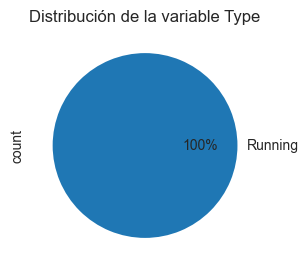

In [151]:
# Análisis de la variable Type
print(df['Type'].value_counts())

# Grafica de torta de la variable Type
plt.figure(figsize=(3, 3))
df['Type'].value_counts().plot.pie(autopct='%1.0f%%', startangle=180)
plt.title('Distribución de la variable Type')
plt.show()

Debido a que Type representa el tipo de actividad deportiva y en el presente análisis sólo se tienen registros de Running, en el proceso de limpieza se eliminará está columna ya que no aporta información valiosa para el modelo.

Name
Bogotá, D.C. Carrera                             18558
Running                                          14549
Coros workout                                    10873
Ciudad de Buenos Aires Carrera                    5706
Cali Carrera                                      5404
                                                 ...  
Xochimilco - 1 km + Fartlek 50 m x 50 m + 4 k        1
Santo Domingo - Caminar: 25' @ Suave                 1
Guayaquil - Recovery and Rest Run                    1
Corregidora - 1600s                                  1
Avellaneda - Fondo en zona 2                         1
Name: count, Length: 46884, dtype: int64


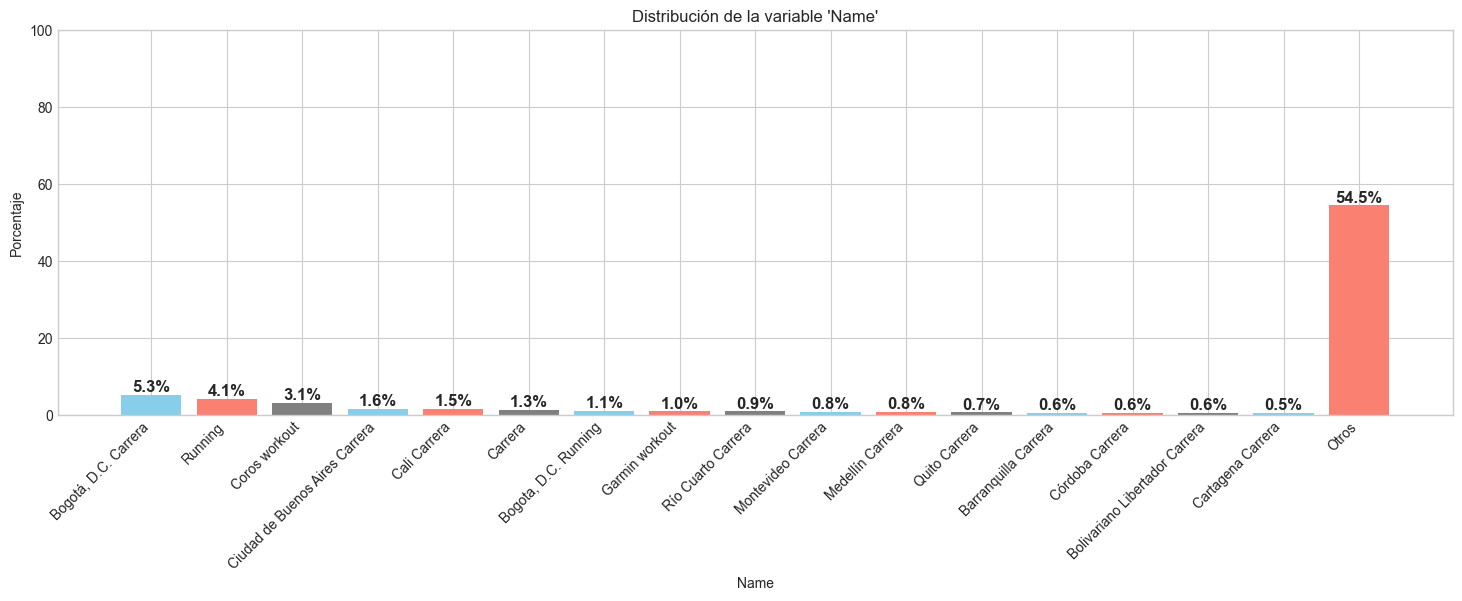

In [152]:
# Análisis de la variable Name
print(df['Name'].value_counts())

porcentajes = (df.value_counts('Name', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 0.5
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Name")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Name'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los nombres que representan al menos el 0.5% de los nombres encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización de los datos.

Esta variable representa el nombre de la actividad que le coloca el reloj o el usuario manualmente, esta variable no es relevante para el análisis por lo que en el proceso de limpieza se eliminará.

In [153]:
# Análisis de la variable StartTimeUtc
print(df['StartTimeUtc'].value_counts())

StartTimeUtc
2025-02-16 10:20:30.0000000 +00:00    11
2025-02-16 10:20:34.0000000 +00:00    10
2025-02-16 10:20:33.0000000 +00:00     9
2025-02-14 13:42:18.0000000 +00:00     7
2025-02-16 10:20:29.0000000 +00:00     7
                                      ..
2024-11-17 00:11:10.0000000 +00:00     1
2024-11-16 02:13:03.0000000 +00:00     1
2024-11-16 01:44:36.0000000 +00:00     1
2024-10-06 20:38:56.0000000 +00:00     1
2025-02-22 21:32:14.0000000 +00:00     1
Name: count, Length: 336508, dtype: int64


La variable StartTimeUtc representa la fecha y hora en la cual se inició la actividad, en los siguientes pasos se podría transformar en nuevas columnas que representen cada valor por separado para poder realizar un mejor análisis de su valor.

In [154]:
# Análisis de SourceType
print(df['SourceType'].value_counts())
(df.value_counts('SourceType', normalize=True) * 100).round(2).astype(str) + '%'

SourceType
Garmin    321978
Coros      11248
Polar       9628
Wahoo       4287
Suunto      3965
Apple         89
Name: count, dtype: int64


SourceType
Garmin    91.68%
Coros       3.2%
Polar      2.74%
Wahoo      1.22%
Suunto     1.13%
Apple      0.03%
Name: proportion, dtype: object

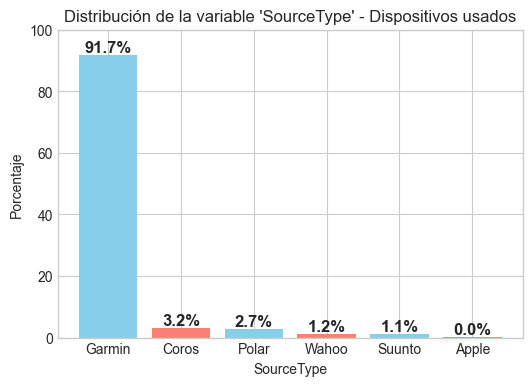

In [155]:
porcentajes = (df.value_counts('SourceType', normalize=True) * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(porcentajes.index, porcentajes, color=['skyblue', 'salmon'])

# Agregar las etiquetas
for bar, porcentaje in zip(bars, porcentajes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceType")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceType' - Dispositivos usados")
plt.ylim(0, 100)
plt.show()

En la gráfica anterior, se observa que Garmin domina ampliamente como la marca más utilizada. Esto podría introducir sesgos en el modelo, ya que la distribución está fuertemente inclinada hacia esta marca. Por ello, durante el proceso de limpieza, evaluaremos qué acciones tomar con esta variable, dado que el dataset muestra un claro desbalance.

In [156]:
# Análisis de la variable SourceName
print(df['SourceName'].value_counts())
(df.value_counts('SourceName', normalize=True) * 100).round(2).astype(str) + '%'

SourceName
Forerunner 55           26785
Forerunner 235          19261
Forerunner 245 Music    16618
Forerunner 965          15487
Forerunner 45           14207
                        ...  
Apple Watch Ultra           1
Amazfit GTS 4 Mini          1
Instinct Crossover          1
Approach S70 – 42mm         1
Suunto Race S               1
Name: count, Length: 240, dtype: int64


SourceName
Forerunner 55           7.65%
Forerunner 235           5.5%
Forerunner 245 Music    4.75%
Forerunner 965          4.42%
Forerunner 45           4.06%
                        ...  
fenix 6S Solar           0.0%
Suunto Race S            0.0%
Wahoo ELEMNT RIVAL       0.0%
Apple Watch Ultra        0.0%
Amazfit GTS 4 Mini       0.0%
Name: proportion, Length: 240, dtype: object

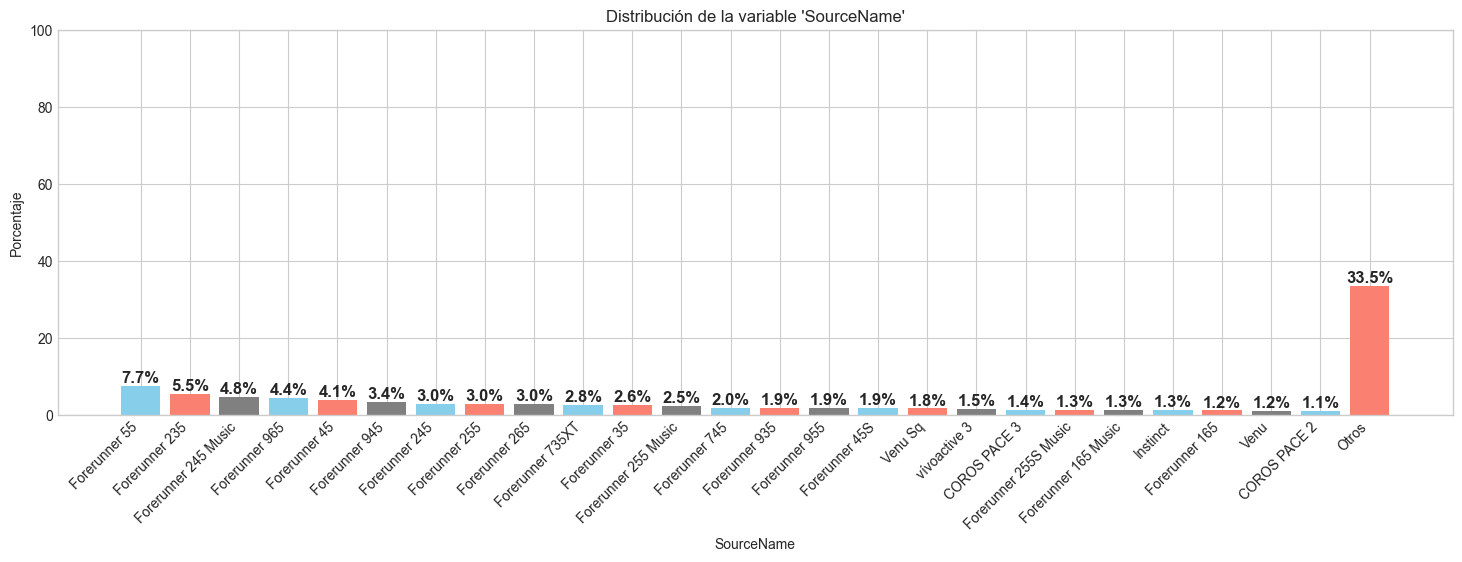

In [157]:
porcentajes = (df.value_counts('SourceName', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceName")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceName'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los modelos que representan al menos el 1% de los modelos encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización delos datos.

En el proceso de limpieza se podría evaluar si se podría eliminar la variable debido a que ya se encuentra representada en la varible sourceType, o se podría realizar algún tratamiento para representar de otra forma.

Warnings
DurationLessThanFiveMinutes                                       18932
DurationLessThanFiveMinutes - AveragePaceInMinutesPerKilometer     5367
TotalElevationGainInMeters                                         4955
AveragePaceInMinutesPerKilometer                                   1671
DurationLessThanFiveMinutes - TotalElevationGainInMeters           1638
                                                                  ...  
Overlapping:1624916                                                   1
Overlapping:1617901                                                   1
Overlapping:1610868                                                   1
Overlapping:1599712                                                   1
Overlapping:2023110                                                   1
Name: count, Length: 107, dtype: int64


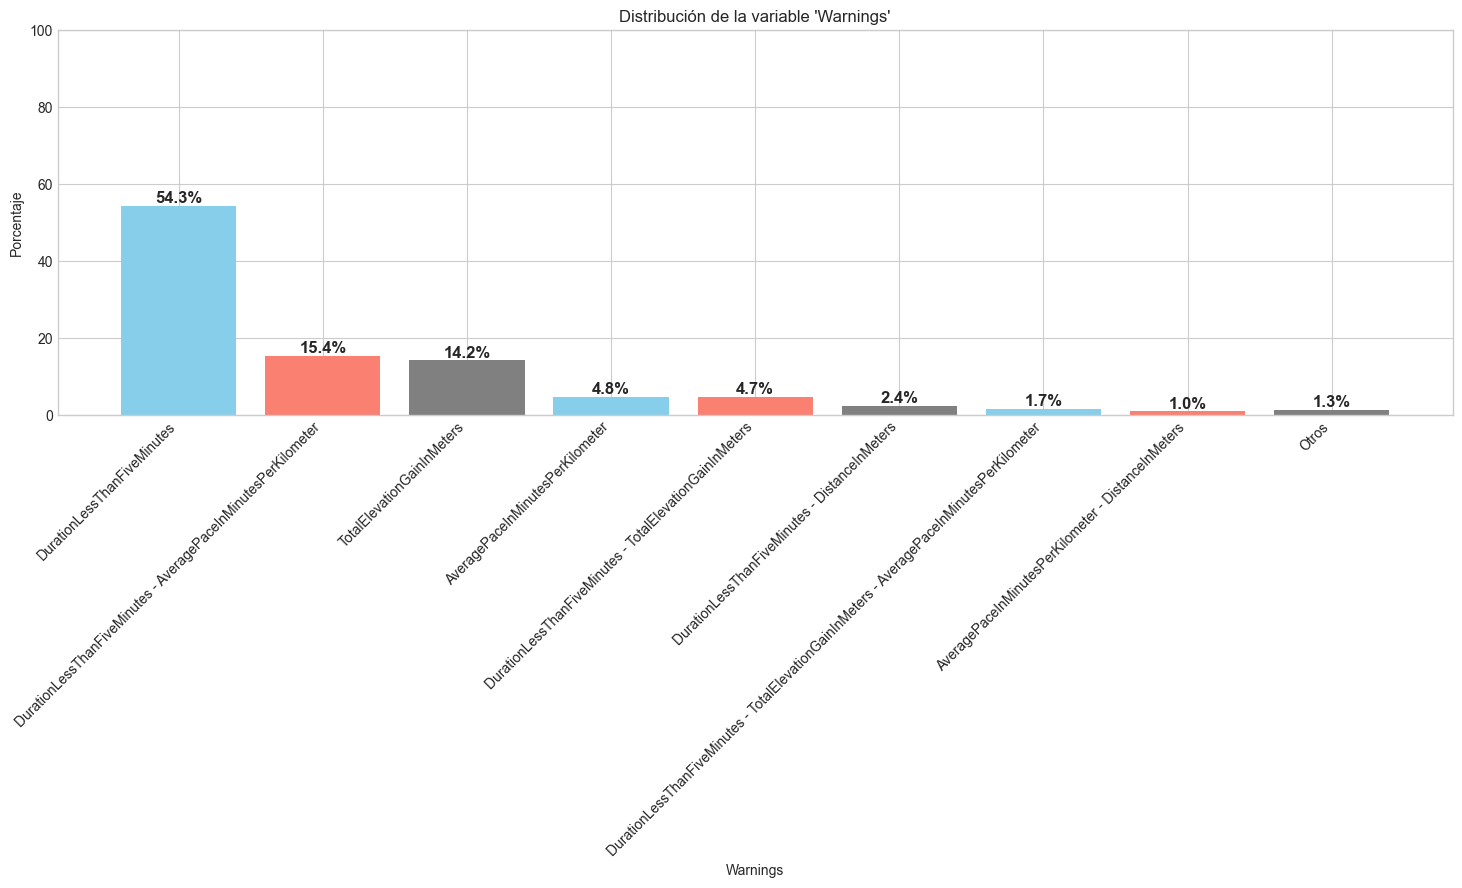

In [158]:
# Análisis de la variable Warnings
print(df['Warnings'].value_counts())

porcentajes = (df.value_counts('Warnings', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Warnings")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Warnings'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

La variable warnings representa la clasificación manual que realiza la empresa para identificar datos atípicos basados en reglas del negocio, por esta razón en el proceso de limpieza se procederá a eliminar esta columna debido a que puede representar un data leakage y por lo tanto sesgaría el modelo.

In [159]:
# Análisis de la variable CreationTime
print(df['CreationTime'].value_counts())

CreationTime
2025-01-19 22:42:04.9000000 +00:00    3
2025-01-19 22:24:21.7966667 +00:00    2
2024-12-30 11:31:48.4336522 +00:00    2
2025-01-30 01:58:06.4000000 +00:00    2
2025-01-12 16:51:58.9911806 +00:00    1
                                     ..
2024-11-21 10:22:36.7311311 +00:00    1
2024-11-21 10:19:58.2600134 +00:00    1
2024-11-21 10:19:53.5676022 +00:00    1
2024-11-21 10:19:44.5586579 +00:00    1
2025-02-22 22:20:45.2143591 +00:00    1
Name: count, Length: 351190, dtype: int64


Al igual que la variable StartTimeUtc, la variable CreationTime representa una fecha; sin embargo, en este caso, indica la fecha y hora en que la actividad fue registrada en la base de datos de la empresa. Dado que esta información no aporta valor al análisis, se eliminará durante el proceso de limpieza.

Tratamiento de variables que inicialmente se determina no son relevantes para lograr el objetivo.
Se mantendrá una copia de df para mantener la información original y poder hacer comparaciones - df_original

In [ ]:
# Eliminar Warnings porque puede presentarse data leakage
df = df.drop('Warnings', axis=1)

# Eliminar UserId porque el ID de un usuario no representa información relevante para el análisis
df = df.drop('UserId', axis=1)

# Eliminar Name representa el nombre de la actividad, pero no es relevante para el análisis
df = df.drop('Name', axis=1)

# Eliminar Type debido a que solo vamos a tomar los registros de Running por lo que solo habría una categoria en Type
df = df.drop('Type', axis=1)

# Para el startTimeUtc decidimos dividir el valor en día, fecha, año y hora
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc'])

df['Year'] = df['StartTimeUtc'].dt.year
df['Month'] = df['StartTimeUtc'].dt.month
df['Day'] = df['StartTimeUtc'].dt.day
df['Hour'] = df['StartTimeUtc'].dt.hour

# Además agregamos una variable adicional que represente el día de la semana en el cual realizó el ejercicio (Donde 0 es lunes, 1 es martes, etc)
df['Day_of_week'] = df['StartTimeUtc'].dt.dayofweek

# Eliminar startTimeUtc
df = df.drop('StartTimeUtc', axis=1)

# Eliminar la variable CreationTime debido a que no es de valor para el análisis porque representa la fecha en la cual se registró la actividad en la base de datos
df = df.drop('CreationTime', axis=1)

# Eliminar la variable SourceType porque su información ya está contenida en SourceName y no aporta información adicional
df = df.drop('SourceName', axis=1)


## Análisis de variables continuas


In [161]:
df_numericas = df.select_dtypes(include=['number'])
df_numericas.columns

Index(['DurationInSeconds', 'DistanceInMeters', 'Steps',
       'AverageSpeedInMetersPerSecond', 'AveragePaceInMinutesPerKilometer',
       'TotalElevationGainInMeters', 'TotalElevationLossInMeters',
       'AverageHeartRateInBeatsPerMinute', 'Year', 'Month', 'Day', 'Hour',
       'Day_of_week'],
      dtype='object')

In [162]:
df_numericas.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week
count,3.511950e+05,3.502160e+05,347187.000000,350201.000000,350143.000000,317879.000000,318270.000000,337981.000000,351195.00000,351195.000000,351195.000000,351195.000000,351195.000000
mean,2.902295e+03,7.597329e+03,7281.422167,2.775515,10.367149,130.991368,130.137395,140.610724,2024.38240,7.154720,15.288347,13.572967,3.099116
std,4.155384e+03,6.691007e+03,6108.132035,2.214866,420.801629,1961.576560,1972.627785,25.404904,0.54406,4.683258,8.695808,5.783349,1.949601
min,-1.764163e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1991.00000,1.000000,1.000000,0.000000,0.000000
25%,1.325000e+03,3.283648e+03,2808.000000,2.357000,5.289326,11.150000,11.000000,132.000000,2024.00000,2.000000,8.000000,10.000000,1.000000
50%,2.581000e+03,6.708120e+03,6568.000000,2.751000,6.057513,32.200000,32.510000,144.000000,2024.00000,10.000000,15.000000,12.000000,3.000000
75%,3.763000e+03,1.009291e+04,10074.000000,3.149000,7.071135,82.000000,83.829982,155.000000,2025.00000,11.000000,22.000000,18.000000,5.000000
max,8.019640e+05,1.148765e+06,220378.000000,997.690002,209166.666667,784072.300000,783765.800000,239.000000,2025.00000,12.000000,31.000000,23.000000,6.000000


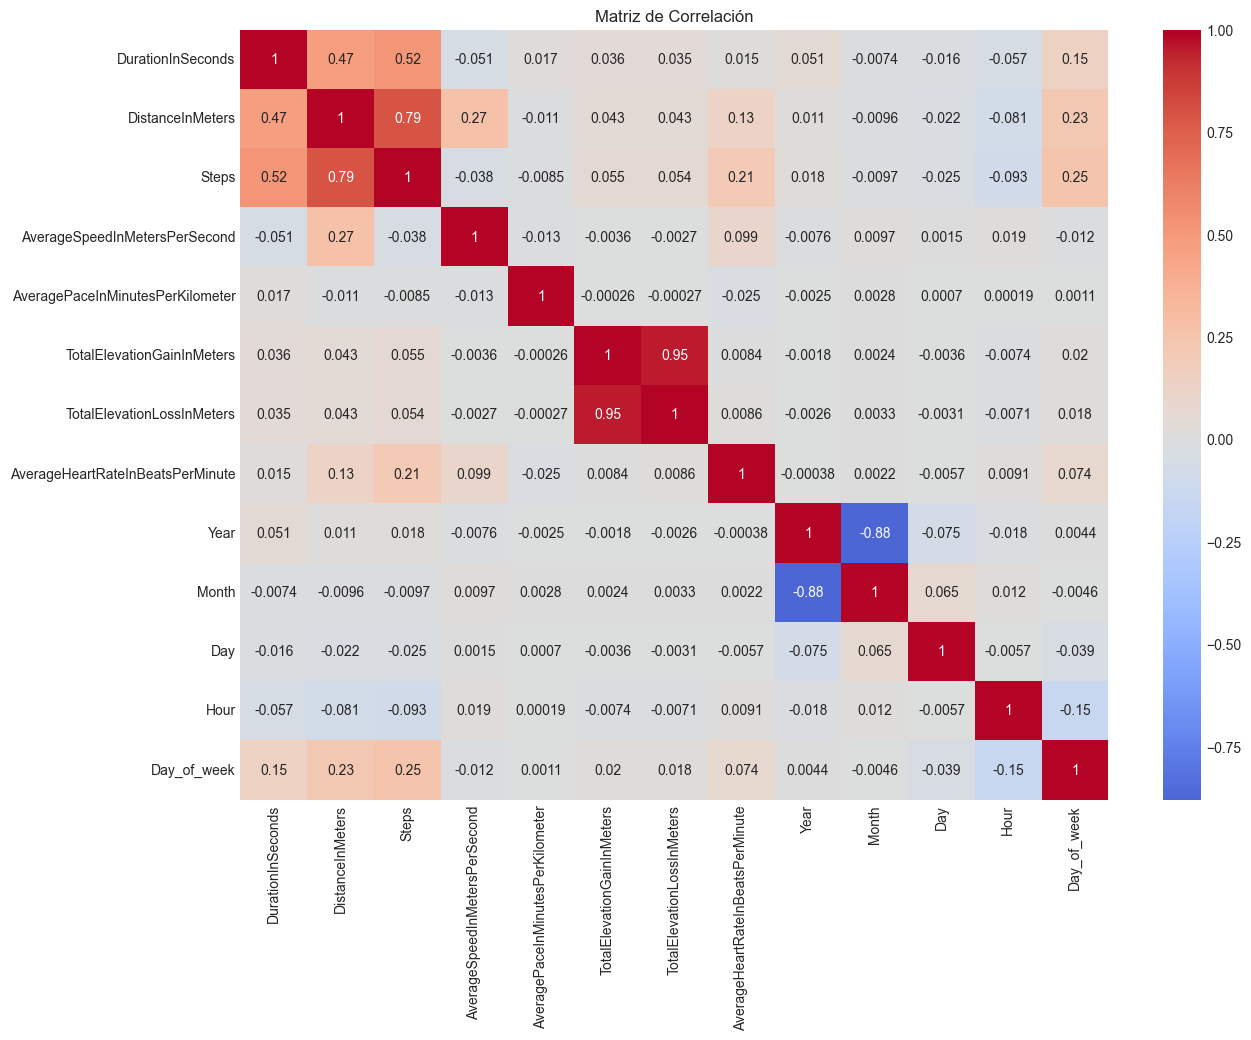

In [163]:
# Crear matriz de correlación
corr_matrix = df_numericas.corr()

# Heatmap de la matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


En la matriz de confusión se puede observar un alta correlación positiva entre las variables Steps y DistancesInMeters por lo que se puede apreciar una relación lineal. Además se ve una correlación muy alta entre las variables TotalElevationGainInMeters y TotalElevationLossInMeters, está correlación alta puede mostrar una posible colinealidad debido a que ambas representan la misma variable pero medida en perdida o ganancia por lo que se deberá realizar algún tratamiento para evitar la colinealidad. Además, también se puede observar correlación positiva pero en menor medida entre Steps y DurationInSeconds, DistanceInMeters y DurationInSeconds. Las anteriores correlaciones positivas indican que si una variable aumenta la otra también.

In [164]:
integer_columns = df.select_dtypes(include=['int64']).columns
print("Variables enteras en el dataset:", integer_columns)


Variables enteras en el dataset: Index(['DurationInSeconds'], dtype='object')


Podemos observar que la unica variable que es entera es la duración en segundos.

#### Análisis de DurationInSeconds

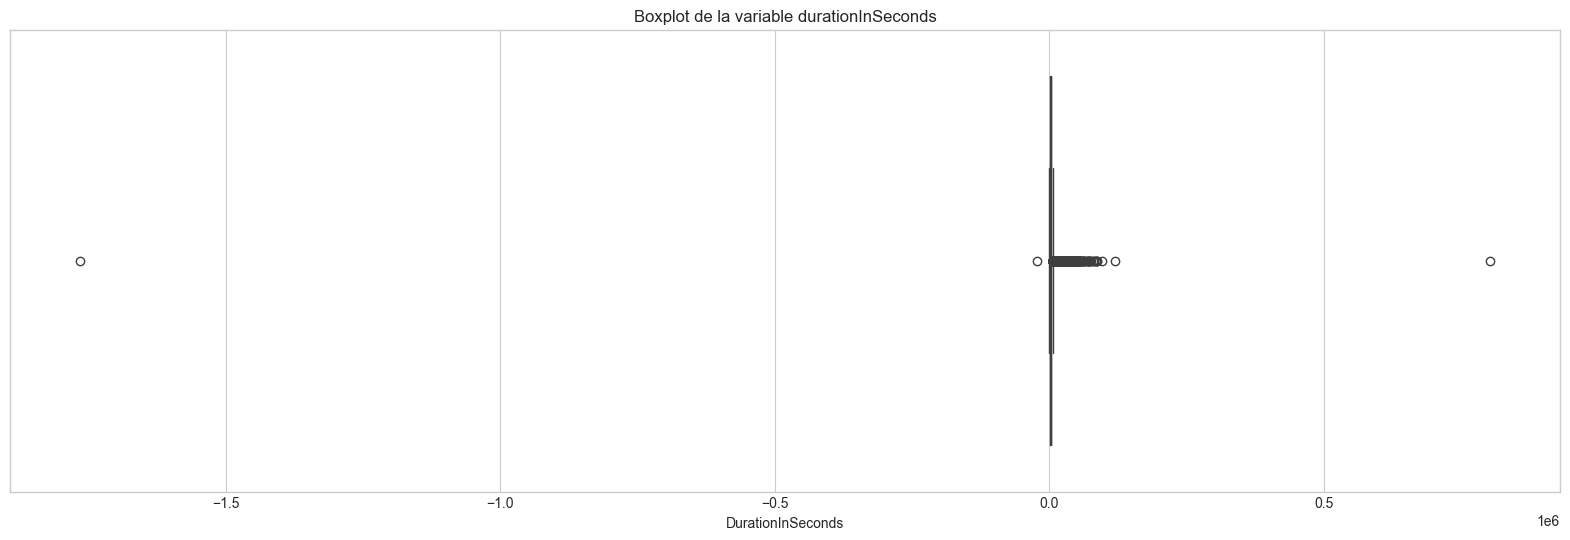

In [165]:
# Grafica de boxplot de  DurationInSeconds
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='DurationInSeconds')
plt.title('Boxplot de la variable durationInSeconds')
plt.show()


Podemos observar que la variable de duración contiene valores negativos y valores iguales a cero. Además, se puede observar la presencia de datos atípicos que se salen de la media.

In [166]:
df['DurationInSeconds'].describe()

count    3.511950e+05
mean     2.902295e+03
std      4.155384e+03
min     -1.764163e+06
25%      1.325000e+03
50%      2.581000e+03
75%      3.763000e+03
max      8.019640e+05
Name: DurationInSeconds, dtype: float64

Tiempos nulos o negativos no tienen sentido práctico en nuestro análisis, así que se eliminarán del dataset

In [167]:
len(df[(df['DurationInSeconds']<=0)])

207

Se puede observar que se cuenta con 207 registros de duración en segundos menores o iguales a cero. Por lo que se procedera a eliminarlos:

In [168]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] > 0)]

Para facilitar el análisis inicial se eliminarán los 2 registros que superan los 100000 segundos que representan más de 27 horas continuas.

In [169]:
len(df[(df['DurationInSeconds']>100000)])

2

In [170]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] < 100000)]

In [171]:
df['DurationInSeconds'].describe()

count    350986.000000
mean       2906.486578
std        2552.759128
min           1.000000
25%        1328.000000
50%        2582.000000
75%        3764.000000
max       95739.000000
Name: DurationInSeconds, dtype: float64

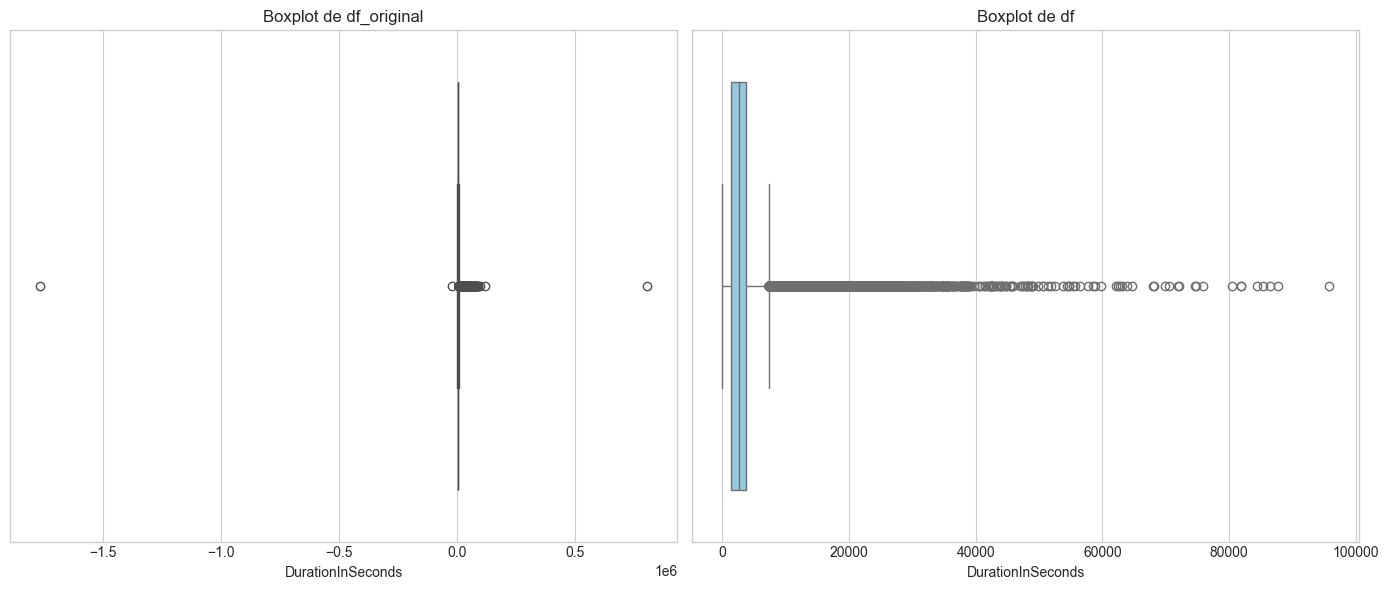

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

sns.boxplot(data=df_original, x='DurationInSeconds', color='orange', ax=axes[0])
axes[0].set_title('Boxplot de df_original')

sns.boxplot(data=df, x='DurationInSeconds', color='skyblue', ax=axes[1])
axes[1].set_title('Boxplot de df')

plt.tight_layout() 
plt.show()

En el gráfico podemos observar que parece que hay muchos valores atípicos pero esto se debe a que una gran cantidad de registros tiene una duración muy corta.

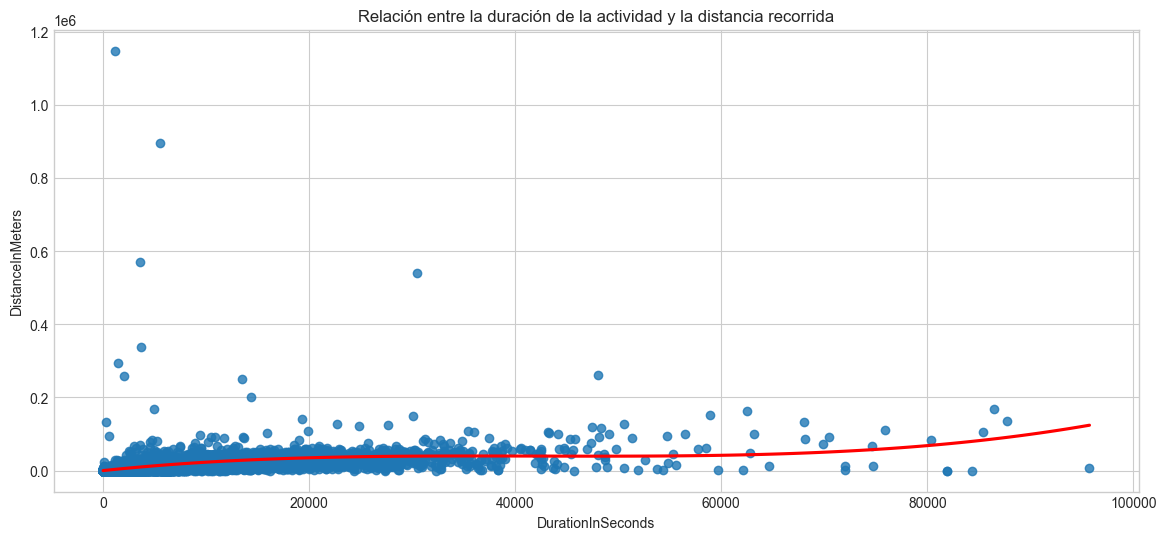

In [174]:
# Relación entre la duración de la actividad y la distancia recorrida con linea de regresion cuadratica
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='DistanceInMeters', order=3, ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y la distancia recorrida')
plt.show()

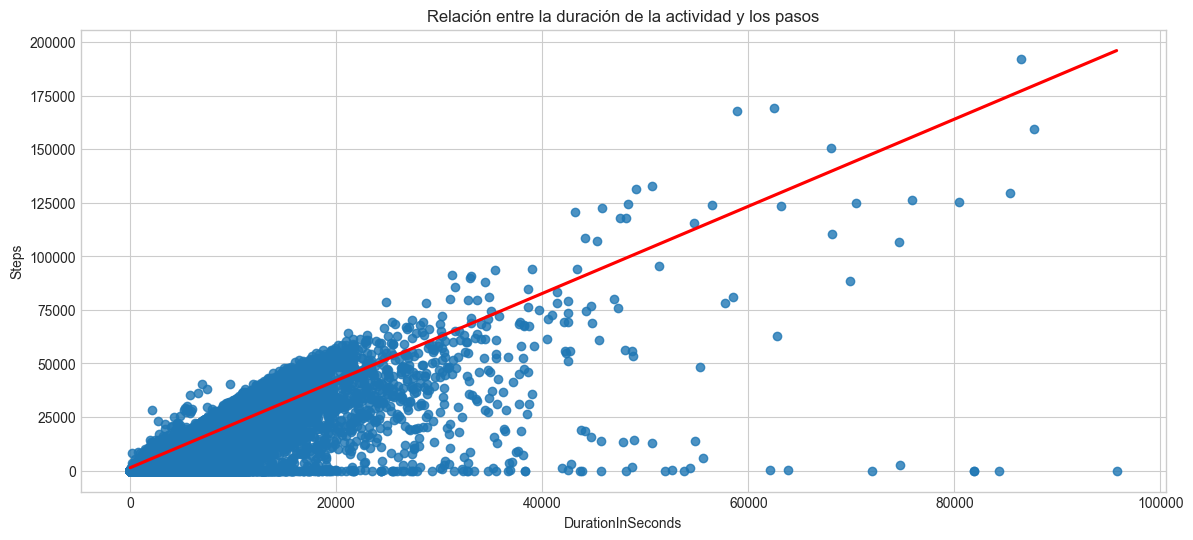

In [175]:
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y los pasos')
plt.show()

### Análisis de DistanceInMeters

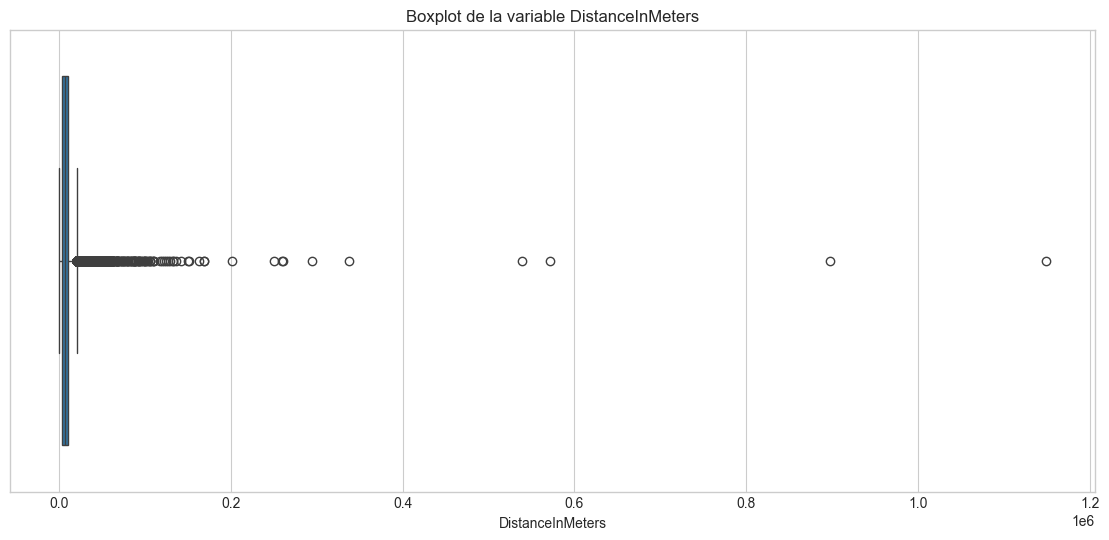

In [176]:
# Grafica de boxplot de DistanceInMeters
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='DistanceInMeters')
plt.title('Boxplot de la variable DistanceInMeters')
plt.show()

In [177]:
len(df[(df['DistanceInMeters']<=0)])

508


Esta variable tiene 508 registros menores o iguales a 0. Considerando que estamos analizando una actividad deportiva de tipo Running, registros sin distancia válida no serán útiles para el análisis

In [178]:
# Eliminar registros con distancia menor o igual a 0
df = df[(df["DistanceInMeters"] > 0)]

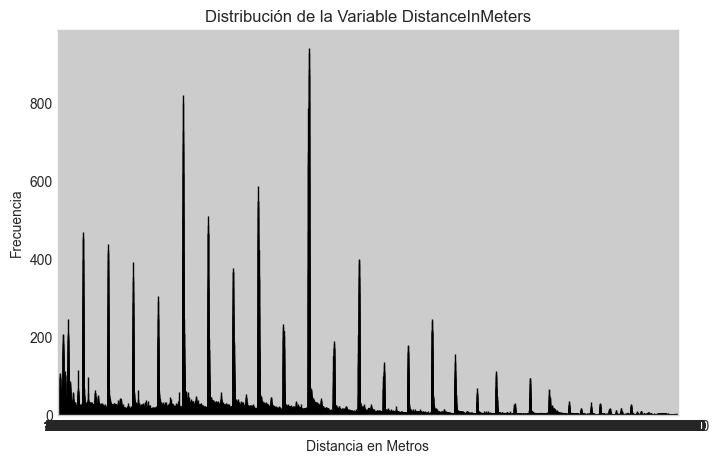

In [179]:
# Conteo de datos solo con números enteros para la variable DistanceInMeters. Esto solo con fines analíticos, no se afectará el dataset original
acumuladorDistancias = df['DistanceInMeters'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladorDistancias.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Distancia en Metros')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable DistanceInMeters')
plt.xticks(rotation=0)

plt.show()

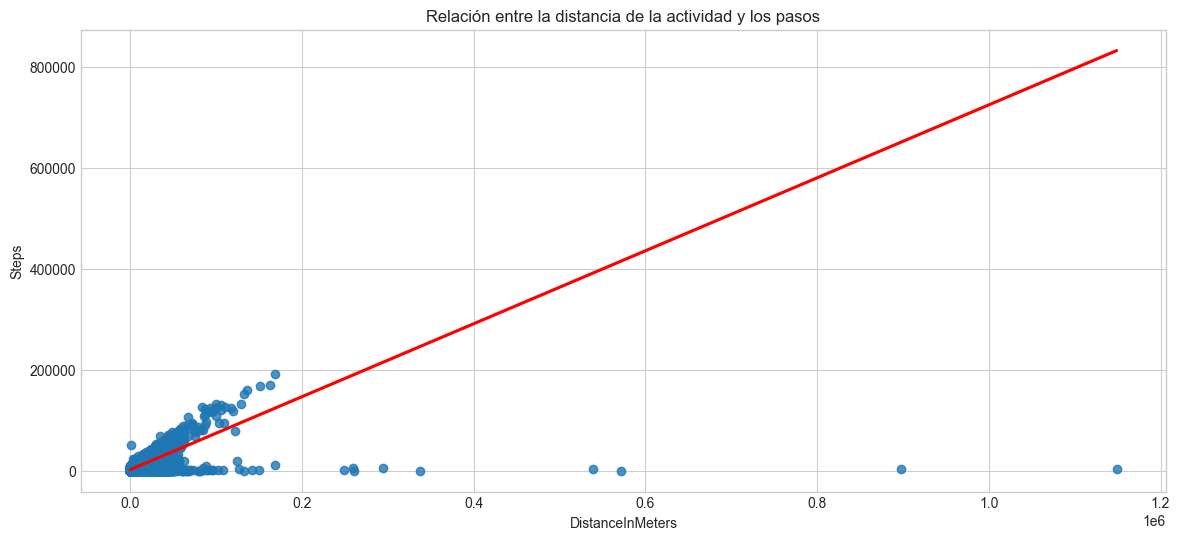

In [180]:
# Relación entre la distancia de la actividad y los pasos
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DistanceInMeters', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la distancia de la actividad y los pasos')
plt.show()

### Análisis de AverageSpeedInMetersPerSecond

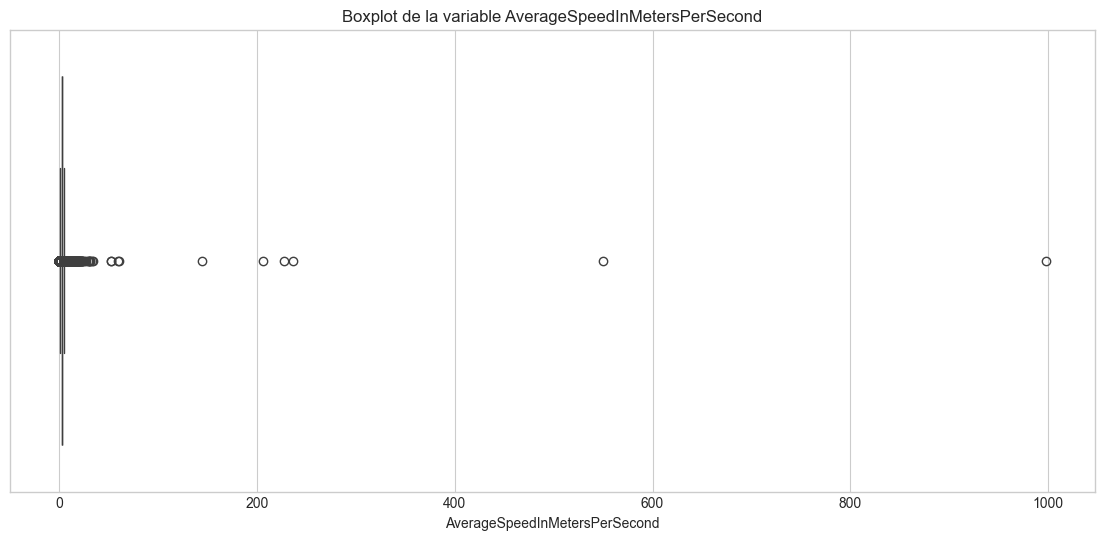

In [181]:
# Grafica de boxplot de AverageSpeedInMetersPerSecond
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AverageSpeedInMetersPerSecond')
plt.title('Boxplot de la variable AverageSpeedInMetersPerSecond')
plt.show()

In [182]:
# Cantidad de registros con velocidad promedio menor o igual a 0
len(df[(df['AverageSpeedInMetersPerSecond']<=0)])

16

Se pueden obsevar 16 registros de velocidad menores o iguales a cero por lo que se eliminarán debido a que no tendrían validez para el análisis realizado.

In [183]:
df = df[(df["AverageSpeedInMetersPerSecond"] > 0)]

### Análisis de AveragePaceInMinutesPerKilometer

In [187]:
df['AveragePaceInMinutesPerKilometer'].describe()

count    349462.000000
mean          9.227601
std         163.101218
min           1.524390
25%           5.294367
50%           6.060606
75%           7.074137
max       37500.000000
Name: AveragePaceInMinutesPerKilometer, dtype: float64

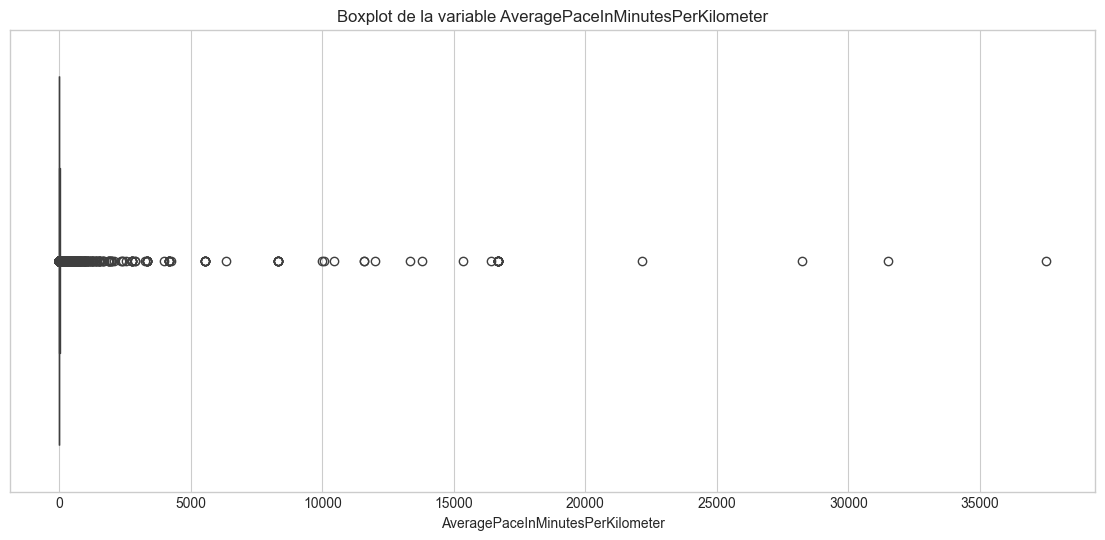

In [188]:
# Grafica de boxplot de AveragePaceInMinutesPerKilometer
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AveragePaceInMinutesPerKilometer')
plt.title('Boxplot de la variable AveragePaceInMinutesPerKilometer')
plt.show()

Para el caso del ritmo los valores atípicos se observan de dos formas, la primera cuando el ritmo es muy bajo debido a que entre menor sea el ritmo significa que la persona corre más rapido; por otro lado si el ritmo es muy alto significa que la persona esta caminando o esta en reposo. 

In [189]:
# Cantidad de registros con ritmo promedio menor o igual a 0
len(df[(df['AveragePaceInMinutesPerKilometer']<=0)])

0

### Análisis de TotalElevationGainInMeters y TotalElevationLossInMeters

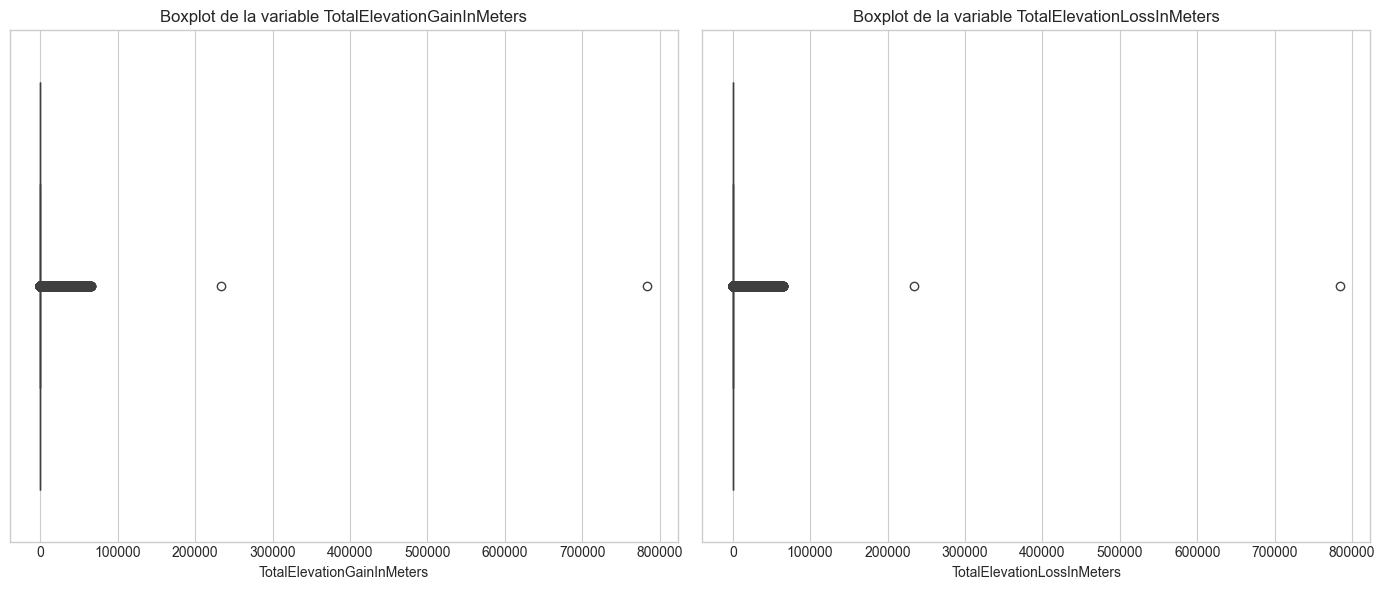

In [191]:
# Crear una figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafica de boxplot de TotalElevationGainInMeters
sns.boxplot(data=df, x='TotalElevationGainInMeters', ax=axes[0])
axes[0].set_title('Boxplot de la variable TotalElevationGainInMeters')

# Grafica de boxplot de TotalElevationLossInMeters
sns.boxplot(data=df, x='TotalElevationLossInMeters', ax=axes[1])
axes[1].set_title('Boxplot de la variable TotalElevationLossInMeters')

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

Eliminar los 2 outliers que entorpecen el entendimiento de las variables TotalElevationGainInMeters y TotalElevationLossInMeters

In [192]:
print(len(df[(df["TotalElevationGainInMeters"] > 100000)]), len(df[(df["TotalElevationLossInMeters"] > 100000)]))

2 2


In [193]:
df = df[(df["TotalElevationGainInMeters"] < 100000)]
df = df[(df["TotalElevationLossInMeters"] < 100000)]

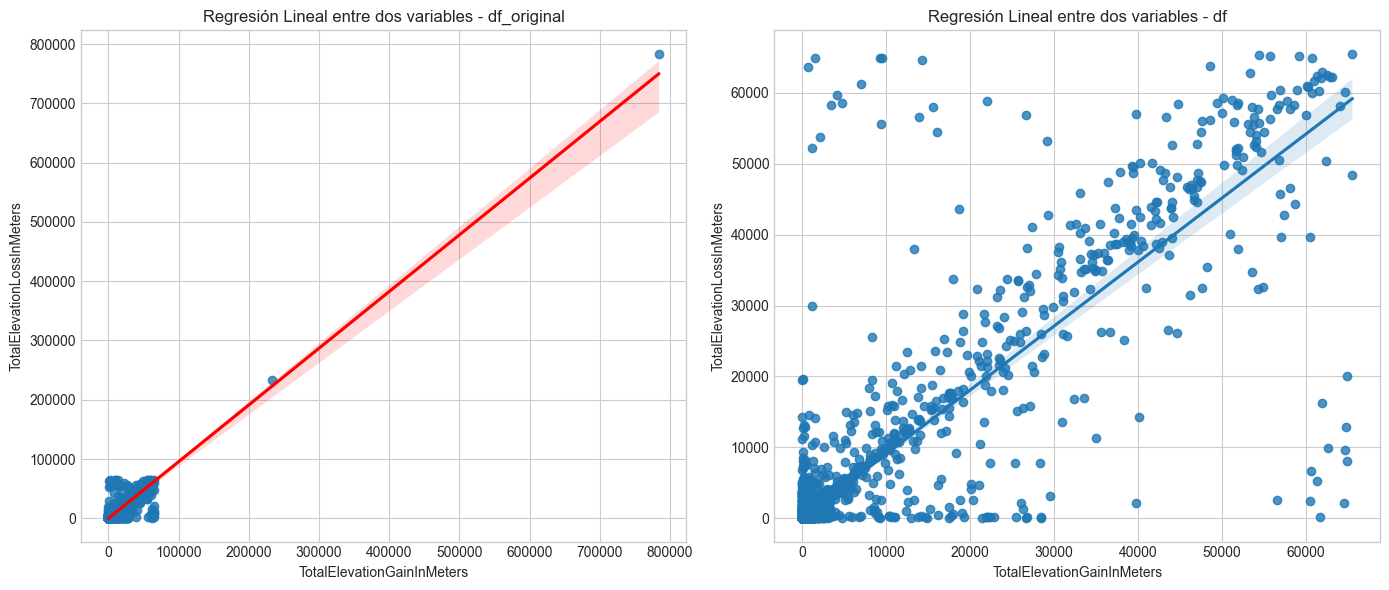

In [194]:
# Se analizará TotalElevationGainInMeters y TotalElevationLossInMeters debido a que presentan una correlación muy alta

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x=df_original["TotalElevationGainInMeters"], y=df_original["TotalElevationLossInMeters"], ax=axes[0], line_kws={'color':'red'})
axes[0].set_title('Regresión Lineal entre dos variables - df_original')

sns.regplot(x=df["TotalElevationGainInMeters"], y=df["TotalElevationLossInMeters"], ax=axes[1])
axes[1].set_title('Regresión Lineal entre dos variables - df')
plt.tight_layout() 
plt.show()

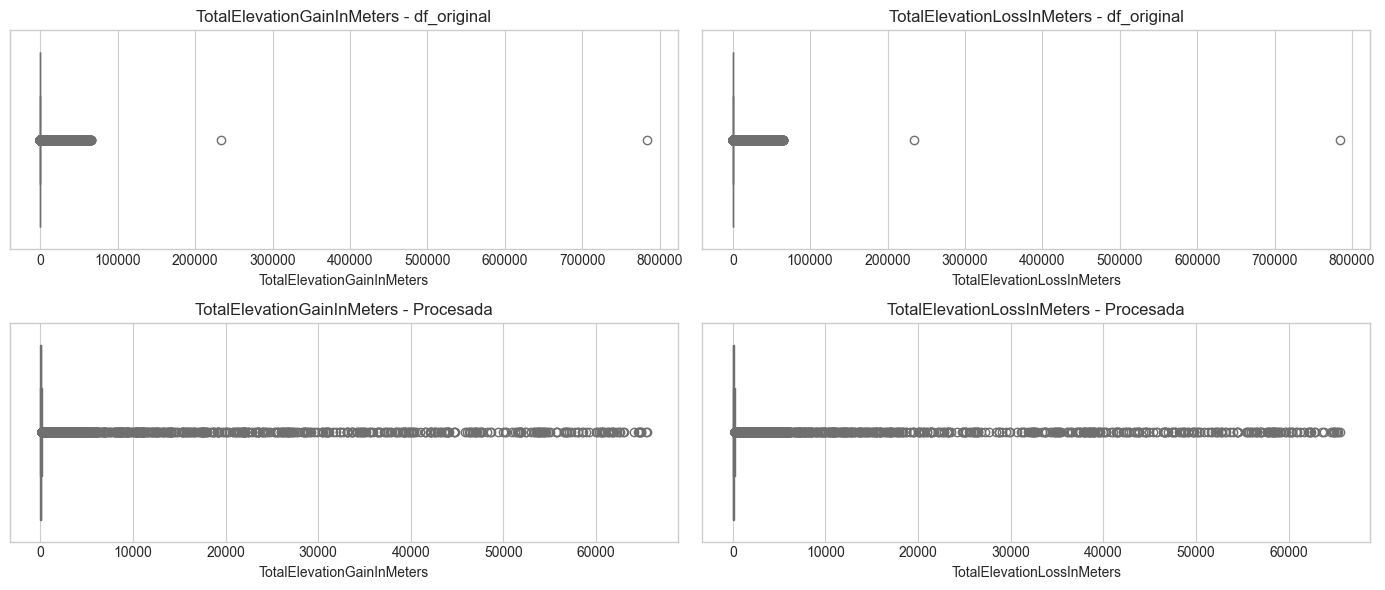

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
sns.boxplot(data=df_original, x='TotalElevationGainInMeters', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('TotalElevationGainInMeters - df_original')

sns.boxplot(data=df_original, x='TotalElevationLossInMeters', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('TotalElevationLossInMeters - df_original')

sns.boxplot(data=df, x='TotalElevationGainInMeters', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('TotalElevationGainInMeters - Procesada')

sns.boxplot(data=df, x='TotalElevationLossInMeters', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('TotalElevationLossInMeters - Procesada')

plt.tight_layout() 
plt.show()

In [196]:
df['TotalElevationGainInMeters'].describe()

count    305950.000000
mean        130.726041
std        1336.929632
min           0.000000
25%          12.900000
50%          34.000000
75%          85.000000
max       65513.100000
Name: TotalElevationGainInMeters, dtype: float64

Debido a que las variables manejadas individualmente tiene un alto porcentaje de nulos:
TotalElevationGainInMeters: 33316 registros nulos
TotalElevationLossInMeters: 32925 registros nulos
Y se consideran importantes para el sistema de detección, se hace una transformación clasificando el terreno recorrido por el usuario como: 
- **Flat**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
- **Uphill**: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
- **Downhill**: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
- **Mixed**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0

In [197]:
# Debido a que se observa un alta correlación entre ambas variables lo que nos indica que si se usan como predictoras para el modelo podemos tener problemas de colinealidad
"""
Se considera que la variable TotalElevationGainInMeters y TotalElevationLossInMeters aportan información relevante para el análisis, 
por tanto se computará una columna adicional que represente el tipo de terreno en el cual se realizó la actividad
    1. Flat: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
    2. Uphill: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
    3. Downhill: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
    4. Mixed: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0
"""
df['TerrainType'] = 'Flat'  # Initialize with 'Flat'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] == 0), 'TerrainType'] = 'Uphill'
df.loc[(df['TotalElevationGainInMeters'] == 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Downhill'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Mixed'


# Eliminar las variables usadas para crear TerrainType
df = df.drop('TotalElevationGainInMeters', axis=1)
df = df.drop('TotalElevationLossInMeters', axis=1)

In [198]:
df.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,SourceType,Year,Month,Day,Hour,Day_of_week,TerrainType
0,2308,6050.10,6802.0,2.622,6.356471,145.0,Garmin,2024,9,30,20,0,Mixed
2,320,770.48,856.0,2.407,6.924248,114.0,Garmin,2024,9,30,23,0,Mixed
3,1895,5005.62,5254.0,2.642,6.308352,146.0,Garmin,2024,9,30,23,0,Mixed
4,4386,10376.22,11452.0,2.365,7.047216,143.0,Garmin,2024,9,30,21,0,Mixed
5,3054,8013.14,8424.0,2.624,6.351625,152.0,Garmin,2024,9,30,23,0,Mixed


DistanceInMeters                                            \
                       count         mean          std   min       25%   
TerrainType                                                              
Downhill              2437.0  4430.399695  3717.051023  2.00  1320.660   
Flat                  7266.0  6692.929918  6182.321536  0.01  2255.445   
Mixed               294154.0  8433.987692  5891.463259  2.61  4872.850   
Uphill                2093.0  5608.204955  5178.172077  3.00  1623.860   

                                             DurationInSeconds               \
                  50%         75%        max             count         mean   
TerrainType                                                                   
Downhill     3466.650   6509.4900   25013.00            2437.0  1677.442347   
Flat         5808.945  10008.0000  260787.06            7266.0  2872.622351   
Mixed        7509.330  10596.4525  294398.53          294154.0  3222.995866   
Uphill       4918.480   8140.6500   67343.49            2093.0  2170.071667   

             ... AverageSpeedInMetersPerSecond          \
             ...                           75%     max   
TerrainType  ...                                         
Downhill     ...                      3.177000   8.173   
Flat         ...                      3.038667   7.852   
Mixed        ...                      3.106000  10.387   
Uphill       ...                      3.063000   6.648   

            AverageHeartRateInBeatsPerMinute                              \
                                       count        mean        std  min   
TerrainType                                                                
Downhill                              2429.0  138.095513  25.156379  0.0   
Flat                                  7205.0   72.022762  71.841521  0.0   
Mixed                               285202.0  143.382490  19.604955  0.0   
Uphill                                2073.0  134.194404  38.327993  0.0   

                                         
               25%    50%    75%    max  
TerrainType                              
Downhill     127.0  141.0  153.0  186.0  
Flat           0.0   91.0  143.0  198.0  
Mixed        134.0  145.0  156.0  232.0  
Uphill       127.0  144.0  155.0  198.0  

[4 rows x 32 columns]

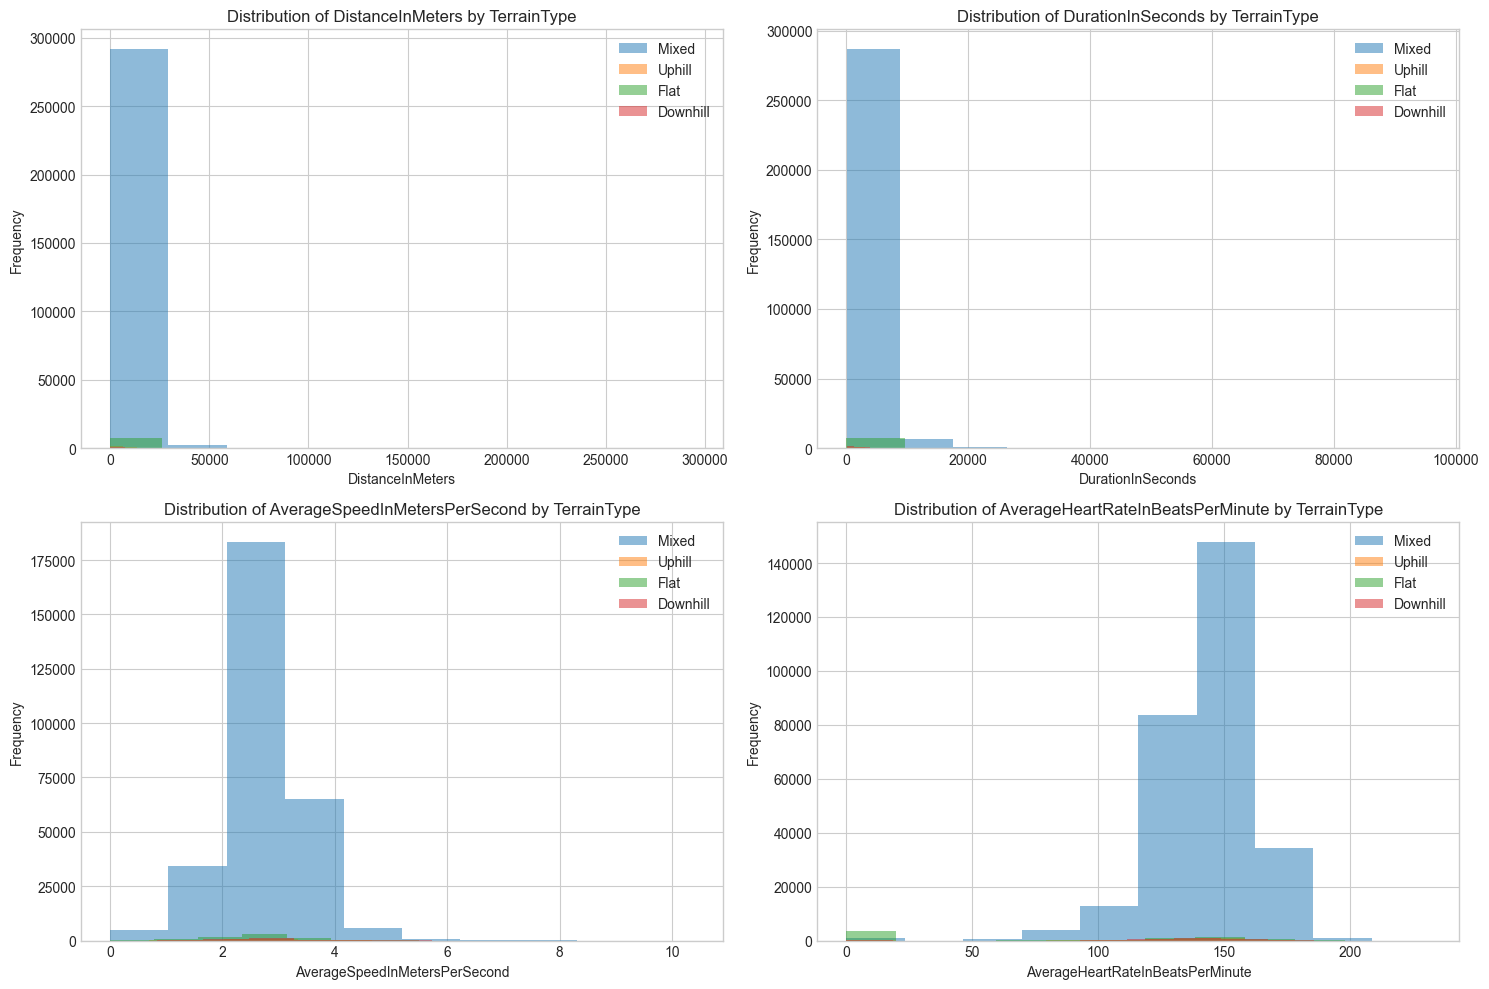

In [199]:
# Numerical variables to analyze
numerical_cols = ['DistanceInMeters', 'DurationInSeconds', 'AverageSpeedInMetersPerSecond', 'AverageHeartRateInBeatsPerMinute']

# 1. Descriptive statistics grouped by TerrainType
descriptive_stats = df.groupby('TerrainType')[numerical_cols].describe()
display(descriptive_stats)

# 2. Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    for terrain_type in df['TerrainType'].unique():
        plt.hist(df[df['TerrainType'] == terrain_type][col].dropna(), alpha=0.5, label=terrain_type)
    plt.title(f'Distribution of {col} by TerrainType')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


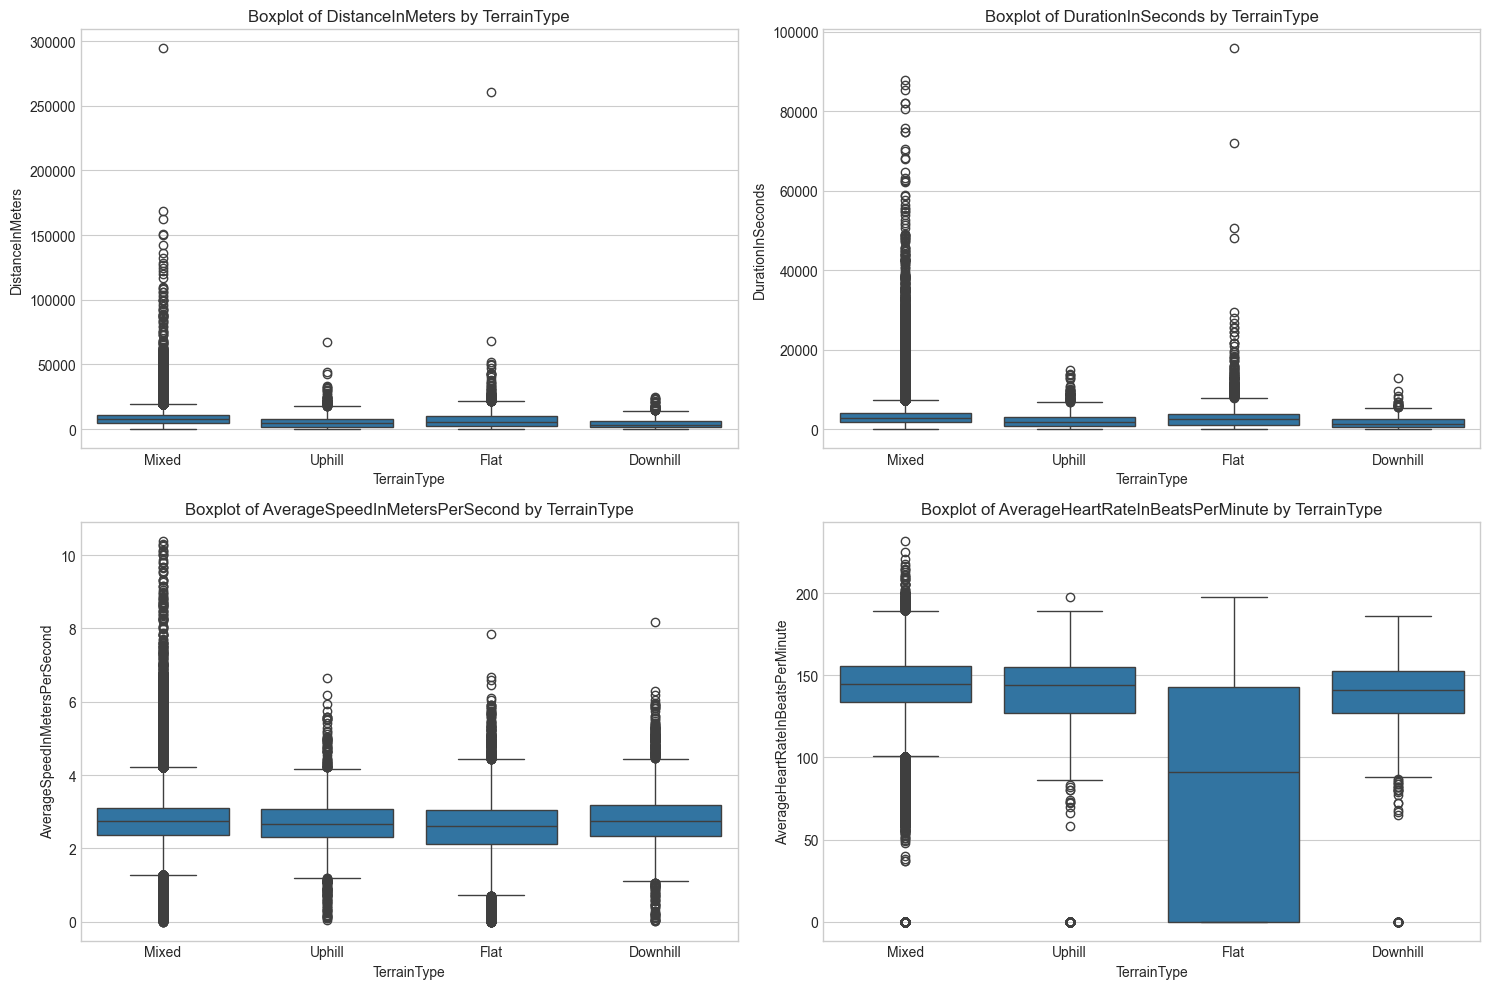

In [200]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='TerrainType', y=col, data=df)
    plt.title(f'Boxplot of {col} by TerrainType')
plt.tight_layout()
plt.show()


En los Boxplot se evidencia que con la clasificación de TerrainType en 4 categorías: Flat, Uphill, Downhill y Mixed, se observa que los terrenos Mixed y Flat presentan una mayor probabilidad de contener datos atípicos en cada una de las variables.

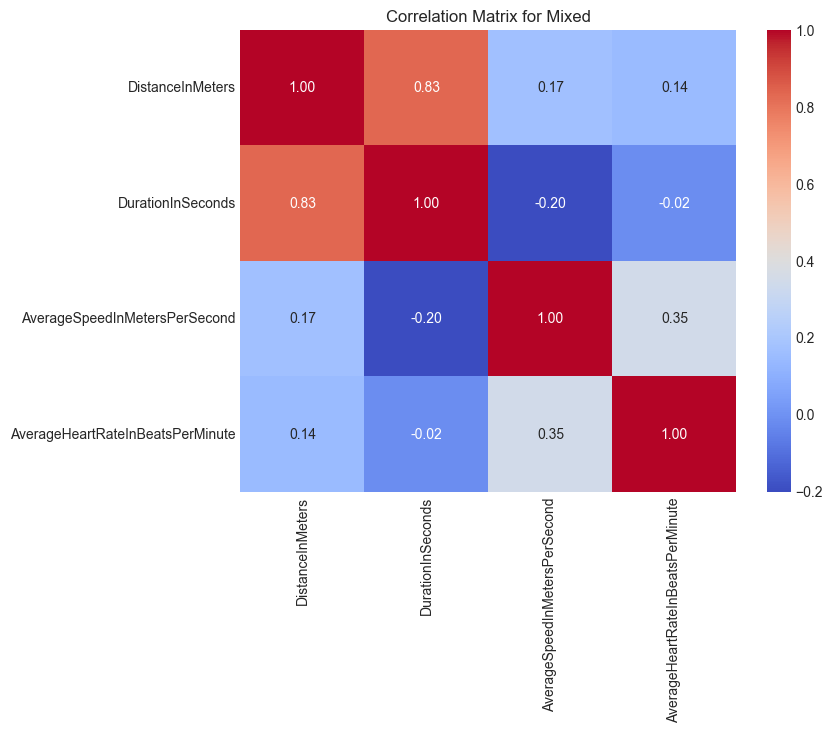

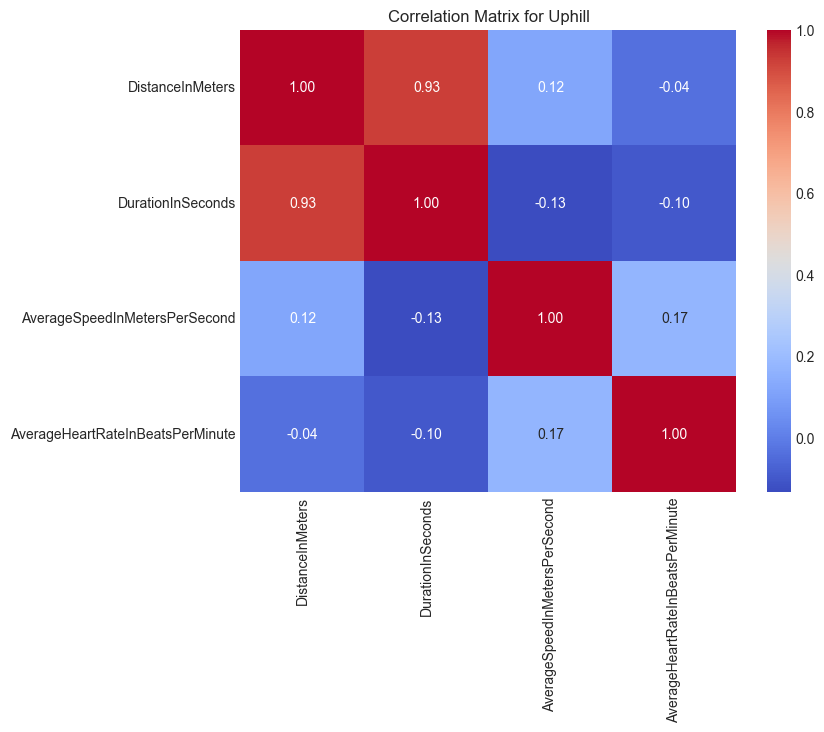

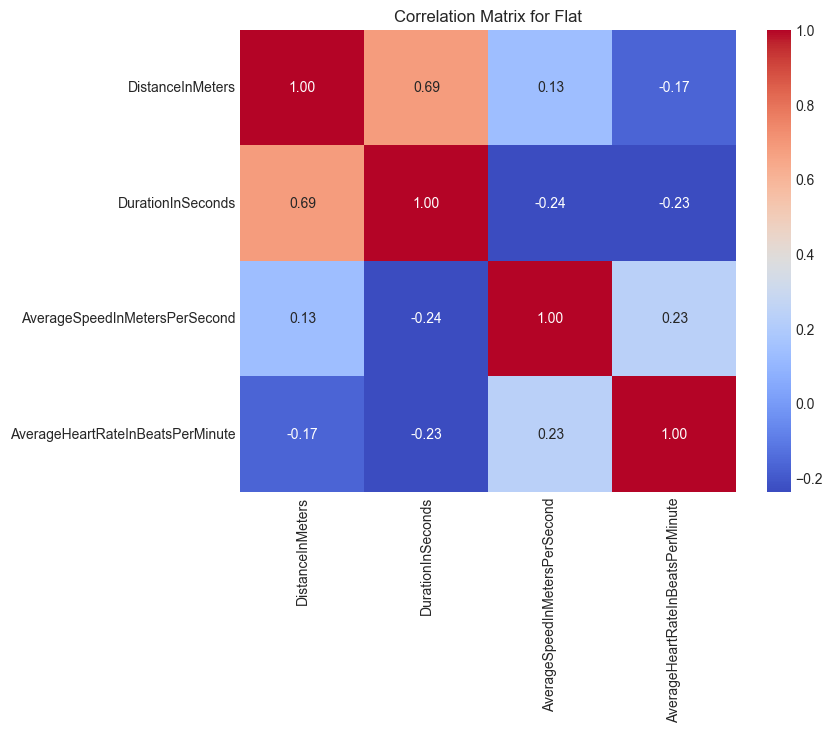

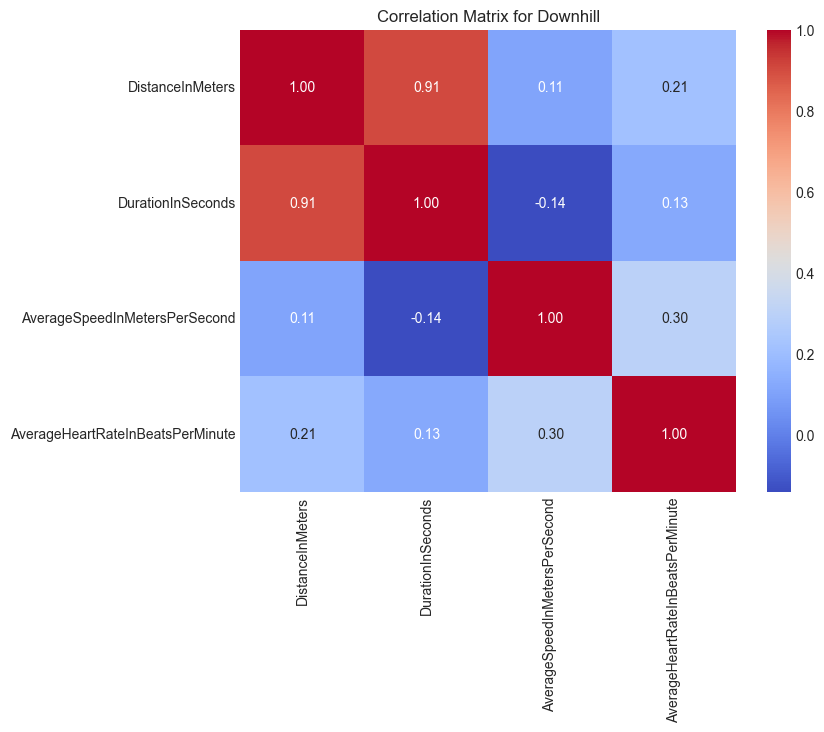

In [201]:
# 3. Correlation matrices and heatmaps
for terrain_type in df['TerrainType'].unique():
    terrain_data = df[df['TerrainType'] == terrain_type]
    correlation_matrix = terrain_data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {terrain_type}')
    plt.show()

### Análisis de AverageHeartRateInBeatsPerMinute

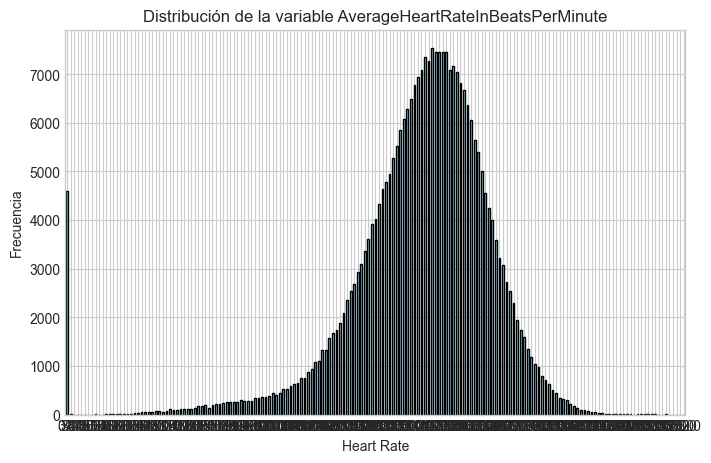

In [205]:
# Contenteo de datos solo con números enteros para la variable AverageHeartRateInBeatsPerMinute. Esto solo con fines analíticos, no se afectará el dataset original
acumuladoRate = df['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Heart Rate')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable AverageHeartRateInBeatsPerMinute')
plt.xticks(rotation=0)

plt.show()

In [206]:
len(df[(df['AverageHeartRateInBeatsPerMinute']==0)])

4598

In [208]:
# Hacer imputación de valores faltantes y nulos en la variable 'AverageHeartRateInBeatsPerMinute' usando KNN y considerando columnas específicas
"""
columnas_para_imputacion = [
    'DurationInSeconds', 
    'DistanceInMeters', 
    'AverageSpeedInMetersPerSecond', 
    'Day', 
    'TerrainType_Downhill', 
    'TerrainType_Flat', 
    'TerrainType_Mixed', 
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=3)  
df_encoded[['AverageHeartRateInBeatsPerMinute']] = imputer.fit_transform(df_encoded[columnas_para_imputacion])[:, -1].reshape(-1, 1)

df_encoded['AverageHeartRateInBeatsPerMinute'].describe()
"""

"\ncolumnas_para_imputacion = [\n    'DurationInSeconds', \n    'DistanceInMeters', \n    'AverageSpeedInMetersPerSecond', \n    'Day', \n    'TerrainType_Downhill', \n    'TerrainType_Flat', \n    'TerrainType_Mixed', \n    'TerrainType_Uphill',\n    'AverageHeartRateInBeatsPerMinute'\n]\n\ndf_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)\n\nimputer = KNNImputer(n_neighbors=3)  \ndf_encoded[['AverageHeartRateInBeatsPerMinute']] = imputer.fit_transform(df_encoded[columnas_para_imputacion])[:, -1].reshape(-1, 1)\n\ndf_encoded['AverageHeartRateInBeatsPerMinute'].describe()\n"

In [211]:
df_encoded = pd.get_dummies(df, columns=['TerrainType'])
df_encoded.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week
count,305950.000000,305950.000000,304361.000000,305950.000000,305950.000000,296909.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000
mean,3195.160932,8341.418210,7991.773568,2.726412,8.072560,141.543422,2024.388197,7.143118,15.278941,13.497388,3.156846
std,2537.449474,5900.658333,6069.240398,0.697438,138.723406,25.116968,0.509076,4.691434,8.691556,5.635723,1.969480
min,1.000000,0.010000,0.000000,0.001000,1.524390,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000
25%,1800.000000,4701.622500,4072.000000,2.363000,5.371146,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000
50%,2814.000000,7397.425000,7230.000000,2.738000,6.091618,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000
75%,3950.000000,10511.832500,10526.000000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000
max,95739.000000,294398.530000,192006.000000,10.387000,37500.000000,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000


In [212]:
columnas_para_imputacion = [
    'DurationInSeconds', 
    'DistanceInMeters', 
    'Steps',
    'AverageSpeedInMetersPerSecond', 
    'Day', 
    'TerrainType_Downhill', 
    'TerrainType_Flat', 
    'TerrainType_Mixed', 
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)
df_encoded['Steps'] = df_encoded['Steps'].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=3)  
df_encoded[columnas_para_imputacion] = imputer.fit_transform(df_encoded[columnas_para_imputacion])
df_encoded.describe()


,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000
mean,3195.160932,8341.418210,8375.603181,2.726412,8.072560,143.679571,2024.388197,7.143118,15.278941,13.497388,3.156846,0.007965,0.023749,0.961445,0.006841
std,2537.449474,5900.658333,5941.804463,0.697438,138.723406,17.799057,0.509076,4.691434,8.691556,5.635723,1.969480,0.088893,0.152266,0.192533,0.082427
min,1.000000,0.010000,1.000000,0.001000,1.524390,37.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1800.000000,4701.622500,4628.000000,2.363000,5.371146,134.000000,2024.000000,2.000000,8.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2814.000000,7397.425000,7502.000000,2.738000,6.091618,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000,0.000000,0.000000,1.000000,0.000000
75%,3950.000000,10511.832500,10711.750000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000,0.000000,0.000000,1.000000,0.000000
max,95739.000000,294398.530000,192006.000000,10.387000,37500.000000,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000


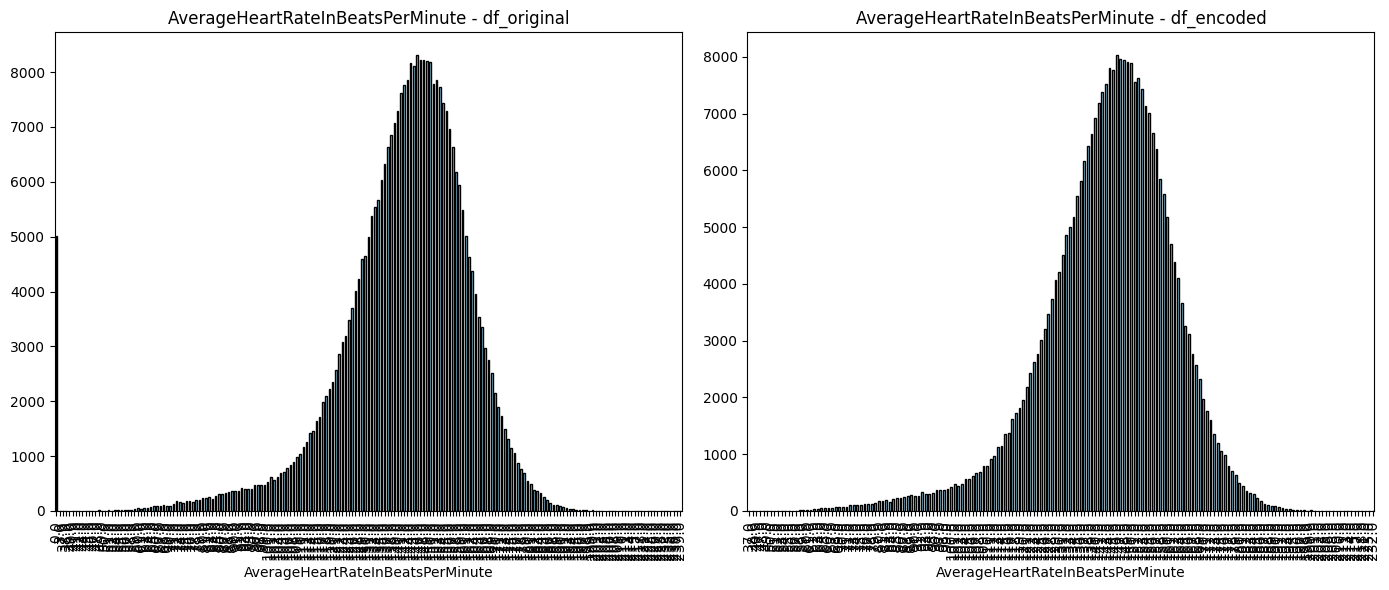

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
acumuladoRate = df_original['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('AverageHeartRateInBeatsPerMinute - df_original')

acumuladoRate = df_encoded['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('AverageHeartRateInBeatsPerMinute - df_encoded')
plt.tight_layout() 
plt.show()

## Análisis de Outliers

* DistanceInMeters: Distancia recorrida durante la actividad, expresada en metros.
* AverageHeartRateInBeatsPerMinute: Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (BPM).
* AveragePaceInMinutesPerKilometer: Ritmo promedio de la actividad, expresado en minutos por kilómetro.


In [ ]:
outlier_cols = ["DistanceInMeters", "AverageSpeedInMetersPerSecond", "AverageHeartRateInBeatsPerMinute"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

# Detección de outliers con el método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Crear boxplots solo con los outliers
df_outliers = pd.DataFrame()
for col in outlier_cols:
    df_outliers = pd.concat([df_outliers, detect_outliers_iqr(df, col)])

df_outliers = df_outliers.drop_duplicates()

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_outliers[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

## Revisión del df resultante después del análisis de variables inicial

In [202]:
df.shape

(305950, 13)

Los datos originales eran (351195, 16), lo que quiere decir que a nivel de registros se ha eliminado el ### de los datos

In [203]:
df.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week
count,305950.000000,305950.000000,304361.000000,305950.000000,305950.000000,296909.000000,305950.000000,305950.000000,305950.000000,305950.000000,305950.000000
mean,3195.160932,8341.418210,7991.773568,2.726412,8.072560,141.543422,2024.388197,7.143118,15.278941,13.497388,3.156846
std,2537.449474,5900.658333,6069.240398,0.697438,138.723406,25.116968,0.509076,4.691434,8.691556,5.635723,1.969480
min,1.000000,0.010000,0.000000,0.001000,1.524390,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000
25%,1800.000000,4701.622500,4072.000000,2.363000,5.371146,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000
50%,2814.000000,7397.425000,7230.000000,2.738000,6.091618,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000
75%,3950.000000,10511.832500,10526.000000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000
max,95739.000000,294398.530000,192006.000000,10.387000,37500.000000,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000


In [204]:
df.isna().sum()

DurationInSeconds                      0
DistanceInMeters                       0
Steps                               1589
AverageSpeedInMetersPerSecond          0
AveragePaceInMinutesPerKilometer       0
AverageHeartRateInBeatsPerMinute    9041
SourceType                             0
Year                                   0
Month                                  0
Day                                    0
Hour                                   0
Day_of_week                            0
TerrainType                            0
dtype: int64

Para poder hacer imputaciones con KNN y que se considere el terreno, es necesario usar One-Hot Encoding para convertirlo en valores numéricos y que el proceso funcione adecuadamente

In [ ]:
df_encoded.isna().sum()

DurationInSeconds                     0
DistanceInMeters                      0
Steps                                 0
AverageSpeedInMetersPerSecond         0
AveragePaceInMinutesPerKilometer      0
AverageHeartRateInBeatsPerMinute      0
SourceName                          982
Year                                  0
Month                                 0
Day                                   0
Hour                                  0
Day_of_week                           0
TerrainType_Downhill                  0
TerrainType_Flat                      0
TerrainType_Mixed                     0
TerrainType_Uphill                    0
dtype: int64

Con los resultados anteriores podemos ver que el proceso de imputación no afectó la disrtibución de las variables

## Estandarización

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['DurationInSeconds', 'DistanceInMeters', 'Steps', 'AverageSpeedInMetersPerSecond', 'AveragePaceInMinutesPerKilometer', 'AverageHeartRateInBeatsPerMinute']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
df_encoded.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,SourceName,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
0,-0.349016,-0.380732,-0.264648,-0.148828,-0.006933,0.074758,Forerunner 35,2024,9,30.0,20,0,0.0,0.0,1.0,0.0
2,-1.130829,-1.255780,-1.265663,-0.450279,-0.005635,-1.665005,Forerunner 255S Music,2024,9,30.0,23,0,0.0,0.0,1.0,0.0
3,-0.511435,-0.553845,-0.525255,-0.120786,-0.007043,0.130879,Forerunner 45,2024,9,30.0,23,0,0.0,0.0,1.0,0.0
4,0.468191,0.336282,0.518185,-0.509167,-0.005354,-0.037485,Forerunner 55,2024,9,30.0,21,0,0.0,0.0,1.0,0.0
5,-0.055640,-0.055376,0.008418,-0.146023,-0.006944,0.467608,Forerunner 55,2024,9,30.0,23,0,0.0,0.0,1.0,0.0


## SVM

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

# 2. One-Class SVM
one_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
one_svm.fit(df_encoded)
svm_pred = one_svm.predict(df_encoded)
svm_anomalies = np.sum(svm_pred == -1)
print('One-Class SVM detected anomalies:', svm_anomalies)


## Kmeans

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_encoded)
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_

distances = np.linalg.norm(df_encoded - centers[cluster_labels], axis=1)
dist_threshold = np.percentile(distances, 95)
cluster_anomalies = np.sum(distances > dist_threshold)
print('KMeans clustering detected anomalies:', cluster_anomalies)

## DBSCAN 

Density-Based Spatial Clustering of Applications with Noise es un algoritmo de clustering que agrupa puntos en función de su densidad y será usado para el proceso de identificación de datos atípicos

In [ ]:
# Eliminar SourceName para hacer el análisis DBSCAN
df_encoded = df_encoded.drop('SourceName', axis=1)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan.fit(df_encoded)

cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame using .loc
df_encoded.loc[:, 'cluster_labels'] = cluster_labels

display(df_encoded.head())

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,cluster_labels
0,-0.349016,-0.380732,-0.264648,-0.148828,-0.006933,0.074758,2024,9,30.0,20,0,0.0,0.0,1.0,0.0,-1
2,-1.130829,-1.255780,-1.265663,-0.450279,-0.005635,-1.665005,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,-1
3,-0.511435,-0.553845,-0.525255,-0.120786,-0.007043,0.130879,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,0
4,0.468191,0.336282,0.518185,-0.509167,-0.005354,-0.037485,2024,9,30.0,21,0,0.0,0.0,1.0,0.0,-1
5,-0.055640,-0.055376,0.008418,-0.146023,-0.006944,0.467608,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,0


PCA en 2 dimensiones

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded.drop(columns=['cluster_labels']))

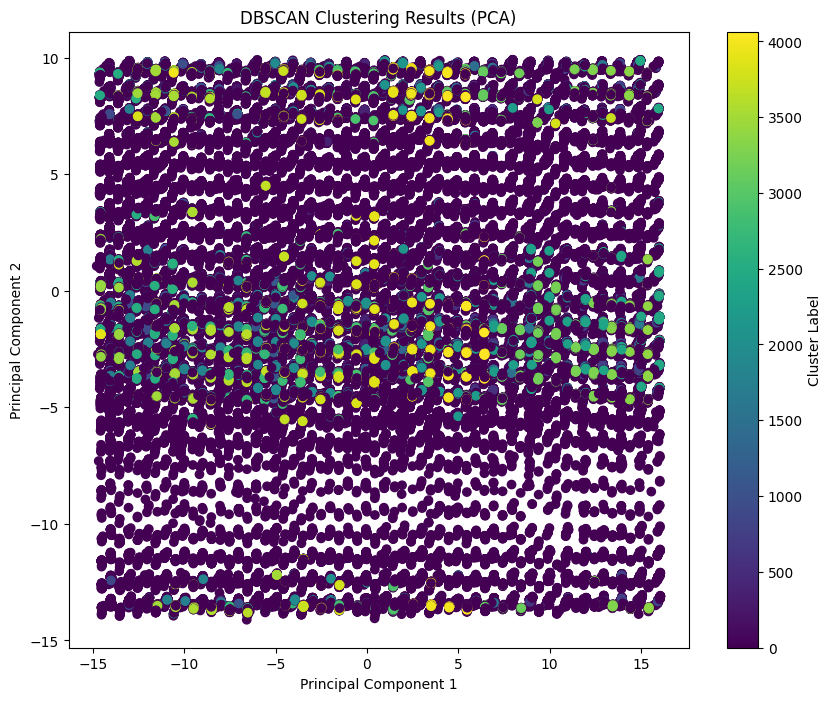

In [ ]:
# Create a scatter plot of the data points, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_encoded['cluster_labels'], cmap='viridis')
plt.title('DBSCAN Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

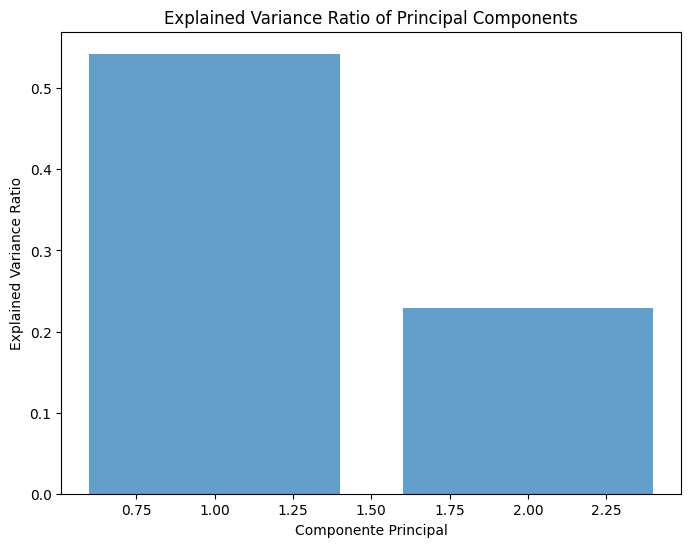

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.7)  
plt.xlabel('Componente Principal')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_encoded.drop(columns=['cluster_labels']))

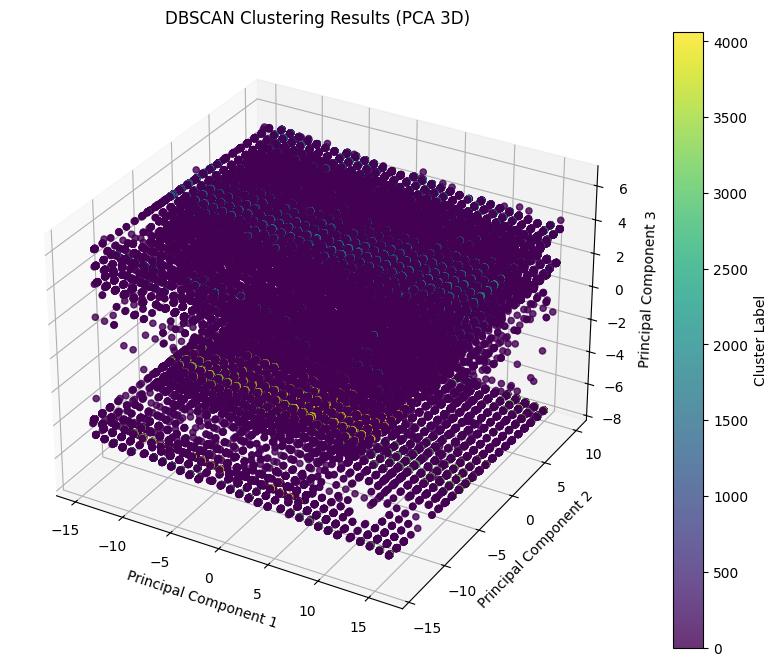

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos con sus clusters
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                     c=df_encoded['cluster_labels'], cmap='viridis', alpha=0.8)

ax.set_title('DBSCAN Clustering Results (PCA 3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.colorbar(scatter, label="Cluster Label")
plt.show()

- Si los puntos forman grupos definidos, significa que DBSCAN ha encontrado patrones claros en los datos. En este caso no es muy evidente

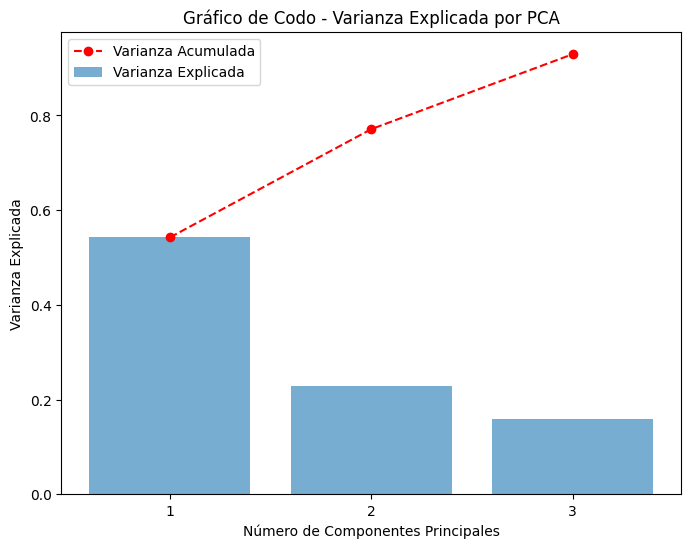

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Suma acumulada

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza Explicada')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label='Varianza Acumulada')

plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Gráfico de Codo - Varianza Explicada por PCA')
plt.legend()
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

- Las barras azules representan la varianza explicada por cada componente principal.
- La línea roja punteada muestra la varianza acumulada a medida que se agregan más componentes.
- Si la varianza acumulada alcanza un valor alto por encima del 80% con pocas componentes, significa que la reducción de dimensionalidad es efectiva y se conserva mucha información de los datos originales. En este caso, parece que con 2 0 3 componentes se puede explicar una gran parte de la varianza total, lo que justificaría el uso de PCA para visualizar y reducir dimensiones.

# Isolation Forest Model

In [ ]:
y = df_encoded['AverageSpeedInMetersPerSecond']
y_binned = pd.qcut(y, q=5, labels=False)
y_binned.value_counts()

AverageSpeedInMetersPerSecond
1    61265
0    61239
2    61185
4    61173
3    61155
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

df_encoded.drop('cluster_labels', axis=1)

X = df_encoded.drop('AverageSpeedInMetersPerSecond', axis=1)
y = df_encoded['AverageSpeedInMetersPerSecond']

# y tiene valores únicos, lo que hace que el stratify falle, por eso dividir la velocidad en 5 categorías es necesario 
y_binned = pd.qcut(y, q=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

IsolationForestModel = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

IsolationForestModel.fit(X_train)

y_train_pred = IsolationForestModel.predict(X_train)
y_test_pred = IsolationForestModel.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Adjust labels to 0 and 1
y_test_adjusted = np.where(y_test_pred == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

accuracy = accuracy_score(y_test, y_test_adjusted)
precision = precision_score(y_test, y_test_adjusted)
recall = recall_score(y_test, y_test_adjusted)
f1 = f1_score(y_test, y_test_adjusted)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_test_adjusted)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.9046304163126593
Precision: 1.0
Recall: 0.9046304163126593
F1-score: 0.949927511988402

Confusion Matrix:
[[    0     0]
 [ 5837 55367]]
